# 미세먼지 유발 영향인자 분석 및 개선안 도출

## 1. 데이터 구성하기

### 1) 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pydoc import help
import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
%matplotlib inline

matplotlib.rc('font', family = 'NanumGothic')
matplotlib.rc('axes', unicode_minus=False)

from matplotlib import rc, font_manager

import warnings
warnings.filterwarnings('ignore')

### 2) 파일 불러오기

In [2]:
df_raw = pd.read_csv("AIR_POLLUTION.csv", encoding = 'cp949', parse_dates=["MeasDate"])

### 3) 데이터 확인하기

In [3]:
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   MeasDate   366 non-null    datetime64[ns]
 1   PM10       365 non-null    float64       
 2   O3         365 non-null    float64       
 3   NO2        365 non-null    float64       
 4   CO         311 non-null    float64       
 5   SO2        365 non-null    float64       
 6   TEMP       366 non-null    float64       
 7   RAIN       366 non-null    float64       
 8   WIND       366 non-null    float64       
 9   WIND_DIR   366 non-null    int64         
 10  HUMIDITY   366 non-null    float64       
 11  ATM_PRESS  366 non-null    float64       
 12  SNOW       366 non-null    float64       
 13  CLOUD      366 non-null    float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 40.2 KB


In [5]:
df_raw.describe()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
count,365.000000,365.000000,365.000000,311.000000,365.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,33.421918,0.023600,0.026814,0.517042,0.003033,13.863798,0.381639,2.225301,209.450820,60.295082,1005.848907,0.022951,5.064016
std,15.937983,0.011896,0.010271,0.152820,0.000632,9.830280,1.122127,0.723171,70.735018,14.534983,8.126823,0.222361,2.986119
min,5.000000,0.002000,0.008000,0.300000,0.002000,-7.950000,0.000000,0.940000,50.000000,17.900000,983.800000,0.000000,0.000000
25%,22.000000,0.014000,0.019000,0.400000,0.003000,5.492500,0.000000,1.722500,160.250000,49.650000,999.400000,0.000000,2.510000
50%,31.000000,0.023000,0.025000,0.500000,0.003000,14.000000,0.000000,2.095000,221.000000,61.050000,1006.450000,0.000000,5.310000
75%,42.000000,0.032000,0.034000,0.600000,0.003000,23.070000,0.115000,2.620000,266.000000,69.950000,1011.575000,0.000000,7.570000
max,101.000000,0.062000,0.059000,1.000000,0.005000,31.720000,11.800000,5.880000,351.000000,95.000000,1025.500000,3.200000,10.000000


## 2. 데이터 정제

In [6]:
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


In [7]:
df_raw['year'] = df_raw['MeasDate'].dt.year
df_raw['month'] = df_raw['MeasDate'].dt.month
df_raw['day'] = df_raw['MeasDate'].dt.day
df_raw['year_month'] = pd.to_datetime(df_raw['MeasDate']).dt.to_period('M')

In [8]:
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,year,month,day,year_month
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70,2019,7,1,2019-07
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83,2019,7,2,2019-07
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29,2019,7,3,2019-07
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54,2019,7,4,2019-07
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92,2019,7,5,2019-07


계절에 따른 구분을 하고자 한다. 계절의 구분은 다음과 같이 정의한다.
- 2019-07~2019-08 : 여름 (2)
- 2019-09~2019-11 : 가을 (3)
- 2019-12~2020-02 : 겨울 (0)
- 2020-03~2020-05 : 봄 (1)
- 2020-06 : 여름 (2)

In [9]:
# 월을 계절로 바꾸기, 0 : 겨울 / 1 : 봄 / 2 : 여름 / 3: 가을
df_raw['season'] = (df_raw['month'] // 3 ) % 4

In [10]:
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,year,month,day,year_month,season
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70,2019,7,1,2019-07,2
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83,2019,7,2,2019-07,2
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29,2019,7,3,2019-07,2
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54,2019,7,4,2019-07,2
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92,2019,7,5,2019-07,2


In [11]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   MeasDate    366 non-null    datetime64[ns]
 1   PM10        365 non-null    float64       
 2   O3          365 non-null    float64       
 3   NO2         365 non-null    float64       
 4   CO          311 non-null    float64       
 5   SO2         365 non-null    float64       
 6   TEMP        366 non-null    float64       
 7   RAIN        366 non-null    float64       
 8   WIND        366 non-null    float64       
 9   WIND_DIR    366 non-null    int64         
 10  HUMIDITY    366 non-null    float64       
 11  ATM_PRESS   366 non-null    float64       
 12  SNOW        366 non-null    float64       
 13  CLOUD       366 non-null    float64       
 14  year        366 non-null    int64         
 15  month       366 non-null    int64         
 16  day         366 non-null  

### 1) 결측치 확인 및 처리

In [12]:
df_raw.isnull().sum()

MeasDate       0
PM10           1
O3             1
NO2            1
CO            55
SO2            1
TEMP           0
RAIN           0
WIND           0
WIND_DIR       0
HUMIDITY       0
ATM_PRESS      0
SNOW           0
CLOUD          0
year           0
month          0
day            0
year_month     0
season         0
dtype: int64

데이터 정제를 위해 결측치를 확인한 결과, 'PM10: 1건, O3: 1건, NO2: 1건, CO2: 55건, SO2: 1건' 존재한다.

CO의 경우 결측치가 많이 존재한다. CO의 결측치를 채울 때, 단순히 전체 평균이 아닌, 계절에 따른 평균을 넣고자 한다.

<AxesSubplot:title={'center':'CO'}, xlabel='[season]'>

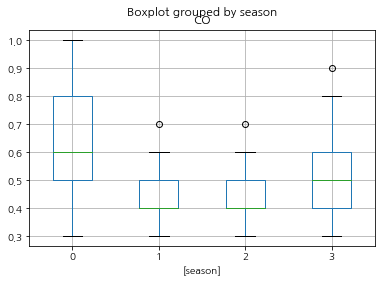

In [13]:
df_raw.boxplot(column="CO", by = ["season"])

<AxesSubplot:title={'center':'PM10'}, xlabel='[season]'>

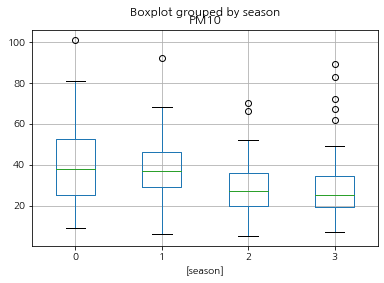

In [14]:
df_raw.boxplot(column="PM10", by =["season"])

In [15]:
#계절별로 묶기
df_raw['CO'].groupby(df_raw['season']).mean()

season
0    0.629670
1    0.447253
2    0.434545
3    0.525676
Name: CO, dtype: float64

In [16]:
df_raw['CO'][df_raw['CO'].isna()]
df_raw['CO'] = df_raw['CO'].fillna(df_raw.groupby("season")["CO"].transform("mean"))

In [17]:
# 계절에 따른 평균 CO값이 잘 들어갔는지 무작위로 선정하여확인

print(df_raw.loc[25:25, ['CO', 'season']])
print(df_raw.loc[59:59, ['CO', 'season']])
print(df_raw.loc[77:77, ['CO', 'season']])

          CO  season
25  0.434545       2
          CO  season
59  0.434545       2
          CO  season
77  0.525676       3


결측치 어느 열에 위치했는지 확인

In [18]:
df_raw['O3'][df_raw['O3'].isna()]

328   NaN
Name: O3, dtype: float64

In [19]:
df_raw['NO2'][df_raw['NO2'].isna()]

328   NaN
Name: NO2, dtype: float64

In [20]:
df_raw['SO2'][df_raw['SO2'].isna()]

328   NaN
Name: SO2, dtype: float64

In [21]:
print(df_raw.loc[328:328])

      MeasDate  PM10  O3  NO2        CO  SO2   TEMP  RAIN  WIND  WIND_DIR  \
328 2020-05-24   NaN NaN  NaN  0.447253  NaN  17.48  1.45  2.85       257   

     HUMIDITY  ATM_PRESS  SNOW  CLOUD  year  month  day year_month  season  
328      83.3      999.4   0.0   8.21  2020      5   24    2020-05       1  


index 328에 결측치가 몰려 있는 것을 확인했다. 따라서 328은 제거하는 것으로 하자.

In [22]:
df_raw = df_raw.drop([328])

In [23]:
df_raw.loc[325:329]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,year,month,day,year_month,season
325,2020-05-21,23.0,0.021,0.025,0.4,0.003,17.02,0.0,2.01,185,56.7,1004.4,0.0,3.46,2020,5,21,2020-05,1
326,2020-05-22,46.0,0.026,0.031,0.5,0.004,18.58,0.0,1.97,181,67.3,1002.9,0.0,8.17,2020,5,22,2020-05,1
327,2020-05-23,50.0,0.022,0.023,0.5,0.003,20.06,0.0,2.19,268,65.9,1001.1,0.0,6.88,2020,5,23,2020-05,1
329,2020-05-25,45.0,0.038,0.034,0.6,0.003,16.70,0.0,2.07,274,80.2,1002.3,0.0,8.17,2020,5,25,2020-05,1


index 328이 삭제되었으므로, 다시 재배열 실시

In [24]:
df_raw.reset_index(drop=True, inplace=True)
df_raw.loc[325:329]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,year,month,day,year_month,season
325,2020-05-21,23.0,0.021,0.025,0.4,0.003,17.02,0.0,2.01,185,56.7,1004.4,0.0,3.46,2020,5,21,2020-05,1
326,2020-05-22,46.0,0.026,0.031,0.5,0.004,18.58,0.0,1.97,181,67.3,1002.9,0.0,8.17,2020,5,22,2020-05,1
327,2020-05-23,50.0,0.022,0.023,0.5,0.003,20.06,0.0,2.19,268,65.9,1001.1,0.0,6.88,2020,5,23,2020-05,1
328,2020-05-25,45.0,0.038,0.034,0.6,0.003,16.70,0.0,2.07,274,80.2,1002.3,0.0,8.17,2020,5,25,2020-05,1
329,2020-05-26,38.0,0.031,0.023,0.5,0.003,16.18,0.3,2.18,278,81.1,999.6,0.0,7.83,2020,5,26,2020-05,1


In [25]:
df_raw.tail()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,year,month,day,year_month,season
360,2020-06-26,19.0,0.039,0.016,0.4,0.003,21.66,0.41,3.12,228,84.0,996.0,0.0,8.73,2020,6,26,2020-06,2
361,2020-06-27,22.0,0.044,0.017,0.4,0.004,23.94,0.00,1.93,217,69.8,995.8,0.0,6.21,2020,6,27,2020-06,2
362,2020-06-28,27.0,0.044,0.009,0.4,0.003,25.03,0.00,2.35,283,71.3,994.7,0.0,2.63,2020,6,28,2020-06,2
363,2020-06-29,36.0,0.026,0.028,0.6,0.003,24.06,1.26,2.48,103,75.5,992.9,0.0,7.58,2020,6,29,2020-06,2
364,2020-06-30,6.0,0.039,0.009,0.3,0.002,20.60,5.60,4.00,50,92.0,983.8,0.0,10.00,2020,6,30,2020-06,2


기존의 index 328가 제거됨에 따라 재배열. 총 365개의 데이터 수가 확인된다. 이로써 아래와 같이 결측치는 존재하지 않는다.

In [26]:
df_raw.isnull().sum()

MeasDate      0
PM10          0
O3            0
NO2           0
CO            0
SO2           0
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
year          0
month         0
day           0
year_month    0
season        0
dtype: int64

### 2) 이상치 확인 및 처리

각 X변수별 IQR 방식으로 이상치를 탐지하고자 한다. 이에 IQR을 계산할 수 있는 사용자 정의 함수를 아래와 같이 생성하였다.

In [27]:
def outlier_iqr(data, column):
    # lower, upper 글로벌 변수 선언하기
    global lower, upper
    
    #4 분위수 기준 정하기
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)
    
    # IQR 계산하기
    iqr = q75 - q25
    
    # outlier cutoff 게산하기
    cut_off = iqr * 1.5
    
    # lower와 upper bound 값 구하기
    lower, upper = q25 - cut_off, q75 + cut_off
    
    print('IQR은', iqr.round(3), '이다.')
    print('lower bound 값은', lower.round(3), '이다.')
    print('upper bound 값은', upper.round(3), '이다.')
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기
    data1 = data[data[column]>upper]
    data2 = data[data[column]<lower]
    
    # 이상치 총 개수 구하기
    return print('총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다.')

**PM10**

In [28]:
outlier_iqr(df_raw, 'PM10')

IQR은 20.0 이다.
lower bound 값은 -8.0 이다.
upper bound 값은 72.0 이다.
총 이상치 개수는 7 이다.


<AxesSubplot:>

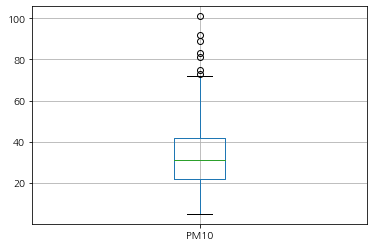

In [29]:
df_raw.boxplot(column="PM10")

**O3**

In [30]:
outlier_iqr(df_raw, 'O3')

IQR은 0.018 이다.
lower bound 값은 -0.013 이다.
upper bound 값은 0.059 이다.
총 이상치 개수는 2 이다.


<AxesSubplot:>

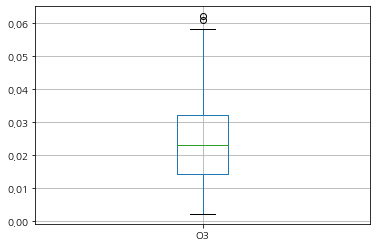

In [31]:
df_raw.boxplot(column="O3")

**NO2**

In [32]:
outlier_iqr(df_raw, 'NO2')

IQR은 0.015 이다.
lower bound 값은 -0.004 이다.
upper bound 값은 0.057 이다.
총 이상치 개수는 1 이다.


**CO**

<AxesSubplot:>

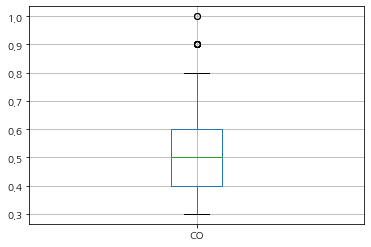

In [33]:
df_raw.boxplot(column="CO")

In [34]:
outlier_iqr(df_raw, 'CO')

IQR은 0.2 이다.
lower bound 값은 0.1 이다.
upper bound 값은 0.9 이다.
총 이상치 개수는 10 이다.


**SO2**

In [35]:
outlier_iqr(df_raw, 'SO2')

IQR은 0.0 이다.
lower bound 값은 0.003 이다.
upper bound 값은 0.003 이다.
총 이상치 개수는 134 이다.


<AxesSubplot:>

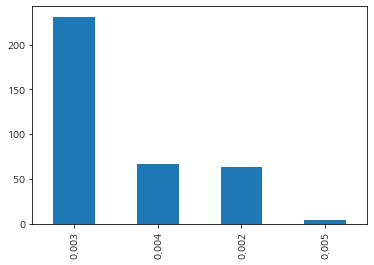

In [36]:
df_count = df_raw["SO2"].value_counts()
df_count.plot.bar()

In [37]:
df_raw[(df_raw["SO2"]>0.004000)]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,year,month,day,year_month,season
124,2019-11-02,67.0,0.010,0.059,0.8,0.005,13.35,0.0,1.42,160,57.2,1010.2,0.0,7.04,2019,11,2,2019-11,3
152,2019-11-30,42.0,0.004,0.049,0.7,0.005,3.79,0.0,1.74,168,41.4,1018.4,0.0,5.46,2019,11,30,2019-11,3
201,2020-01-18,60.0,0.010,0.042,0.8,0.005,0.27,0.0,1.72,237,47.1,1010.9,0.0,1.79,2020,1,18,2020-01,0
351,2020-06-17,46.0,0.044,0.026,0.6,0.005,24.40,0.0,2.04,203,59.8,995.3,0.0,7.17,2020,6,17,2020-06,2


In [38]:
df_raw.value_counts('SO2')

SO2
0.003    231
0.004     67
0.002     63
0.005      4
dtype: int64

확인 결과, SO2 수치가 0.003이 아닌 값들은 이상치라고 분류했다. 하지만 단순히 0.003의 값이 많을 뿐, 그 외의 값인 0.002, 0.004, 0.005가 진정한 이상치라고 판단할 수 없다.

**TEMP**

In [39]:
outlier_iqr(df_raw, 'TEMP')

IQR은 17.62 이다.
lower bound 값은 -20.95 이다.
upper bound 값은 49.53 이다.
총 이상치 개수는 0 이다.


<AxesSubplot:title={'center':'TEMP'}, xlabel='season'>

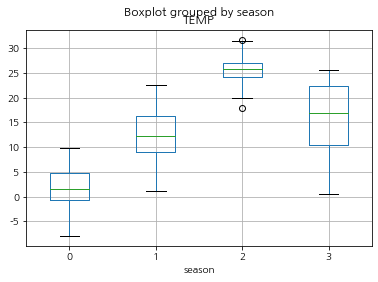

In [40]:
df_raw.boxplot(column="TEMP", by = "season")

**RAIN**

In [41]:
outlier_iqr(df_raw, 'RAIN')

IQR은 0.1 이다.
lower bound 값은 -0.15 이다.
upper bound 값은 0.25 이다.
총 이상치 개수는 74 이다.


**WIND**

In [42]:
outlier_iqr(df_raw, 'WIND')

IQR은 0.9 이다.
lower bound 값은 0.37 이다.
upper bound 값은 3.97 이다.
총 이상치 개수는 8 이다.


<AxesSubplot:>

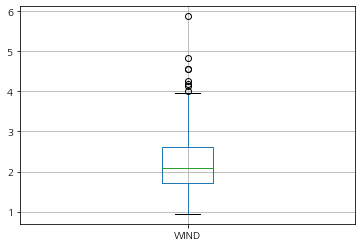

In [43]:
df_raw.boxplot(column="WIND")

**WIND_DIR**

In [44]:
outlier_iqr(df_raw, 'WIND_DIR')

IQR은 106.0 이다.
lower bound 값은 1.0 이다.
upper bound 값은 425.0 이다.
총 이상치 개수는 0 이다.


**HUMIDITY**

In [45]:
outlier_iqr(df_raw, 'HUMIDITY')

IQR은 20.2 이다.
lower bound 값은 19.3 이다.
upper bound 값은 100.1 이다.
총 이상치 개수는 1 이다.


**ATM_PRESS**

In [46]:
outlier_iqr(df_raw, 'ATM_PRESS')

IQR은 12.2 이다.
lower bound 값은 981.1 이다.
upper bound 값은 1029.9 이다.
총 이상치 개수는 0 이다.


<AxesSubplot:>

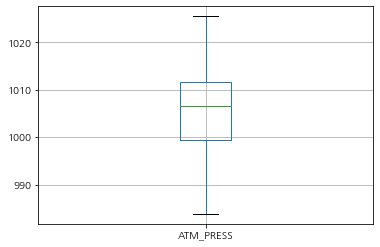

In [47]:
df_raw.boxplot(column="ATM_PRESS")

계절별 저/고기압 살펴보기

In [48]:
df_raw.loc[(df_raw['season']== 0), '계절'] = '겨울'
df_raw.loc[(df_raw['season']== 1), '계절'] = '봄'
df_raw.loc[(df_raw['season']== 2), '계절'] = '여름'
df_raw.loc[(df_raw['season']== 3), '계절'] = '가을'
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,year,month,day,year_month,season,계절
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70,2019,7,1,2019-07,2,여름
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83,2019,7,2,2019-07,2,여름
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29,2019,7,3,2019-07,2,여름
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54,2019,7,4,2019-07,2,여름
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92,2019,7,5,2019-07,2,여름


<AxesSubplot:title={'center':'ATM_PRESS'}, xlabel='[계절]'>

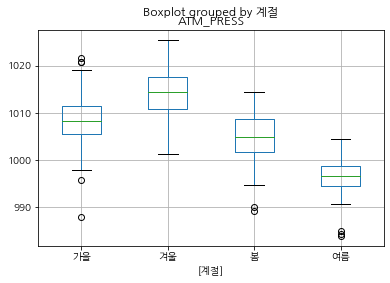

In [49]:
df_raw.boxplot(column="ATM_PRESS", by = ['계절'])

우리 나라에 영향을 주는 고기압으로는 겨울의 시베리아 고기압과 여름의 태평양 고기압이 있는데 이들은 정체성 고기압으로 같은 장소에 오래 머물러 있으면서 계절에 따라 발달하거나 쇠약해진다.


일반적으로 편서풍이 부나, 정체성 고기압과 같은 기타 요인에 의해서 풍향이 달라질 수 있다.

고기압은 상대적으로 기압이 높은 곳이며 저기압은 상대적으로 기압이 낮은 곳을 뜻한다. 고기압은 하강기류이며 저기압은 상승기류이다. 고기압일 때 날씨는 대체로 맑으며, 저기압일 때는 비나 눈이 내리는 경우가 많다.

**SNOW**

In [50]:
outlier_iqr(df_raw, 'SNOW')

IQR은 0.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 0.0 이다.
총 이상치 개수는 6 이다.


**CLOUD**

In [51]:
outlier_iqr(df_raw, 'CLOUD')

IQR은 5.04 이다.
lower bound 값은 -5.06 이다.
upper bound 값은 15.1 이다.
총 이상치 개수는 0 이다.


### 3) 파생변수

<파생 변수 목록>
- 미세먼지 PM10을 WHO 기준으로 좋음, 보통, 나쁨, 매우 나쁨으로 나눔
- 계절
- 바람 방향 (N, S, W, E, NE, SE, SW, NW로 구체적으로 나눔)
- 비와 눈은 단순히 왔다/오지 않았다로 나눔

#### PM10 - 미세먼지 세부 구분

더 세부적으로 PM10의 농도에 따라 미세먼지 심각도를 좋음/보통/나쁨으로 표시하고자 한다. 처음 시도로 환경부 기준으로 0~30(좋음), 30~80(보통), 80~150(나쁨) (data의 PM10 최대값은 101)으로 하였으나, 기준이 너무 느슨하여 '나쁨'에 해당되는 data 개수가 총 5건 뿐으로, 더 기준이 촘촘한 WHO 기분을 따르고자 한다.

WHO 기준으로 '0 ~ 20'(좋음), '21 ~ 45'(보통), '46 ~ 75'(나쁨), '76이상'(매우 나쁨)으로 범주화하였다.

In [52]:
df_raw.loc[df_raw['PM10'] < 20, 'PM10_상세'] = '좋음'
df_raw.loc[(df_raw['PM10'] >= 20) & (df_raw['PM10'] < 46), 'PM10_상세'] = '보통'
df_raw.loc[(df_raw['PM10'] >= 46) & (df_raw['PM10'] < 76), 'PM10_상세'] = '나쁨'
df_raw.loc[(df_raw['PM10'] >= 76), 'PM10_상세'] = '매우_나쁨'
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,...,ATM_PRESS,SNOW,CLOUD,year,month,day,year_month,season,계절,PM10_상세
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,...,995.1,0.0,5.70,2019,7,1,2019-07,2,여름,보통
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,...,998.6,0.0,3.83,2019,7,2,2019-07,2,여름,보통
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,...,998.3,0.0,6.29,2019,7,3,2019-07,2,여름,보통
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,...,996.6,0.0,2.54,2019,7,4,2019-07,2,여름,보통
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,...,993.5,0.0,3.92,2019,7,5,2019-07,2,여름,보통


#### WIND_DIR - 풍향 8방위로 세부 구분

In [53]:
#서풍 / 북서풍 - 중국발

df_raw.loc[(df_raw['WIND_DIR']>=22.5) & (df_raw['WIND_DIR']<67.5), 'WIND_DIR_1'] = 'NE'
df_raw.loc[(df_raw['WIND_DIR']>=67.5) & (df_raw['WIND_DIR']<112.5), 'WIND_DIR_1'] = 'E'
df_raw.loc[(df_raw['WIND_DIR']>=112.5) & (df_raw['WIND_DIR']<157.5), 'WIND_DIR_1'] = 'SE'
df_raw.loc[(df_raw['WIND_DIR']>=157.5) & (df_raw['WIND_DIR']<202.5), 'WIND_DIR_1'] = 'S'
df_raw.loc[(df_raw['WIND_DIR']>=202.5) & (df_raw['WIND_DIR']<247.5), 'WIND_DIR_1'] = 'SW'
df_raw.loc[(df_raw['WIND_DIR']>=247.5) & (df_raw['WIND_DIR']<292.5), 'WIND_DIR_1'] = 'W'
df_raw.loc[(df_raw['WIND_DIR']>=292.5) & (df_raw['WIND_DIR']<337.5), 'WIND_DIR_1'] = 'NW'
df_raw.loc[(df_raw['WIND_DIR']>=337.5) | (df_raw['WIND_DIR']<22.5), 'WIND_DIR_1'] = 'N'

df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,...,SNOW,CLOUD,year,month,day,year_month,season,계절,PM10_상세,WIND_DIR_1
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,...,0.0,5.70,2019,7,1,2019-07,2,여름,보통,W
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,...,0.0,3.83,2019,7,2,2019-07,2,여름,보통,W
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,...,0.0,6.29,2019,7,3,2019-07,2,여름,보통,W
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,...,0.0,2.54,2019,7,4,2019-07,2,여름,보통,W
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,...,0.0,3.92,2019,7,5,2019-07,2,여름,보통,S


#### WIND - 풍속에 따른 세부 구분

boxplot을 참고하여 풍속에 따라 임의로 약함, 중간, 강함, 매우 강함을 나누어 보았다. 기준은 아래와 같다.
- 1.5 이하: 약함
- 1.5 ~ 3 : 중간
- 3 ~  : 강함

In [54]:
df_raw.loc[(df_raw['WIND']< 1.5), 'WIND_STR'] = '약함'
df_raw.loc[(df_raw['WIND']>= 1.5) & (df_raw['WIND']< 3), 'WIND_STR'] = '중간'
df_raw.loc[(df_raw['WIND']>= 3), 'WIND_STR'] = '강함'

df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,...,CLOUD,year,month,day,year_month,season,계절,PM10_상세,WIND_DIR_1,WIND_STR
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,...,5.70,2019,7,1,2019-07,2,여름,보통,W,중간
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,...,3.83,2019,7,2,2019-07,2,여름,보통,W,중간
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,...,6.29,2019,7,3,2019-07,2,여름,보통,W,중간
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,...,2.54,2019,7,4,2019-07,2,여름,보통,W,중간
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,...,3.92,2019,7,5,2019-07,2,여름,보통,S,약함


#### 계절에 따라 구분

In [55]:
df_raw.loc[(df_raw['season']== 0), '계절'] = '겨울'
df_raw.loc[(df_raw['season']== 1), '계절'] = '봄'
df_raw.loc[(df_raw['season']== 2), '계절'] = '여름'
df_raw.loc[(df_raw['season']== 3), '계절'] = '가을'
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,...,CLOUD,year,month,day,year_month,season,계절,PM10_상세,WIND_DIR_1,WIND_STR
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,...,5.70,2019,7,1,2019-07,2,여름,보통,W,중간
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,...,3.83,2019,7,2,2019-07,2,여름,보통,W,중간
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,...,6.29,2019,7,3,2019-07,2,여름,보통,W,중간
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,...,2.54,2019,7,4,2019-07,2,여름,보통,W,중간
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,...,3.92,2019,7,5,2019-07,2,여름,보통,S,약함


#### 비/눈 유무에 따른 구분

비와 눈의 경우 강수량(mm)과 적설량(mm)이지만 단순히 비 혹은 눈이 왔다 안왔다 이분법적으로 접근하고자 한다. 이때, 비/눈이 왔다는 '1', 오지 않았다는 '0'으로 표시하고자 한다.

In [56]:
df_raw.loc[(df_raw['SNOW']> 0), 'SNOW1'] = '1'
df_raw.loc[(df_raw['SNOW']== 0), 'SNOW1'] = '0'
df_raw.loc[(df_raw['RAIN']> 0), 'RAIN1'] = '1'
df_raw.loc[(df_raw['RAIN']== 0), 'RAIN1'] = '0'
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,...,month,day,year_month,season,계절,PM10_상세,WIND_DIR_1,WIND_STR,SNOW1,RAIN1
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,...,7,1,2019-07,2,여름,보통,W,중간,0,0
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,...,7,2,2019-07,2,여름,보통,W,중간,0,0
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,...,7,3,2019-07,2,여름,보통,W,중간,0,0
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,...,7,4,2019-07,2,여름,보통,W,중간,0,0
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,...,7,5,2019-07,2,여름,보통,S,약함,0,0


## 3. 시각화

#### 1) 목표변수

가장 먼저 목표 변수인 PM10의 시간에 따른 추세를 보고자 한다.

No handles with labels found to put in legend.


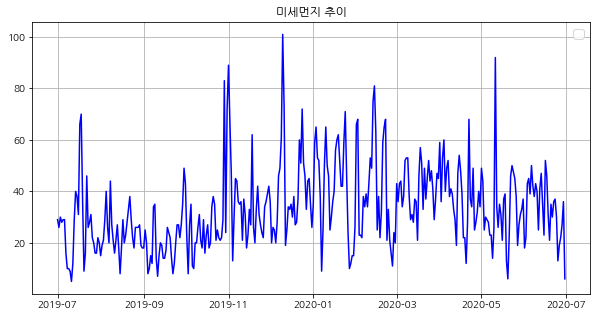

In [57]:
plt.figure(figsize=(10,5))
plt.title("미세먼지 추이")
plt.plot(df_raw['MeasDate'], df_raw["PM10"], "-", color='blue')
plt.grid()
plt.legend(fontsize=13)
plt.show()

<AxesSubplot:>

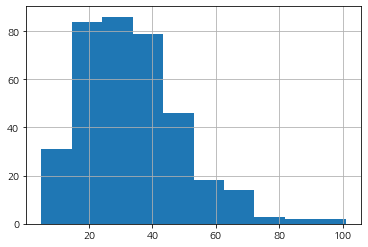

In [58]:
df_raw["PM10"].hist()

#### 2) 설명변수

각 설명변수(X)와 목적변수(Y) 간의 상관관계를 확인해보자.

<설명변수(X) 목록>
- O3
- NO2
- CO
- SO2
- TEMP
- RAIN
- WIND
- WIND_DIR
- HUMIDITY
- ATM_PRESS
- SNOW
- CLOUD

array([[<AxesSubplot:title={'center':'MeasDate'}>,
        <AxesSubplot:title={'center':'PM10'}>,
        <AxesSubplot:title={'center':'O3'}>,
        <AxesSubplot:title={'center':'NO2'}>],
       [<AxesSubplot:title={'center':'CO'}>,
        <AxesSubplot:title={'center':'SO2'}>,
        <AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'RAIN'}>],
       [<AxesSubplot:title={'center':'WIND'}>,
        <AxesSubplot:title={'center':'WIND_DIR'}>,
        <AxesSubplot:title={'center':'HUMIDITY'}>,
        <AxesSubplot:title={'center':'ATM_PRESS'}>],
       [<AxesSubplot:title={'center':'SNOW'}>,
        <AxesSubplot:title={'center':'CLOUD'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'season'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

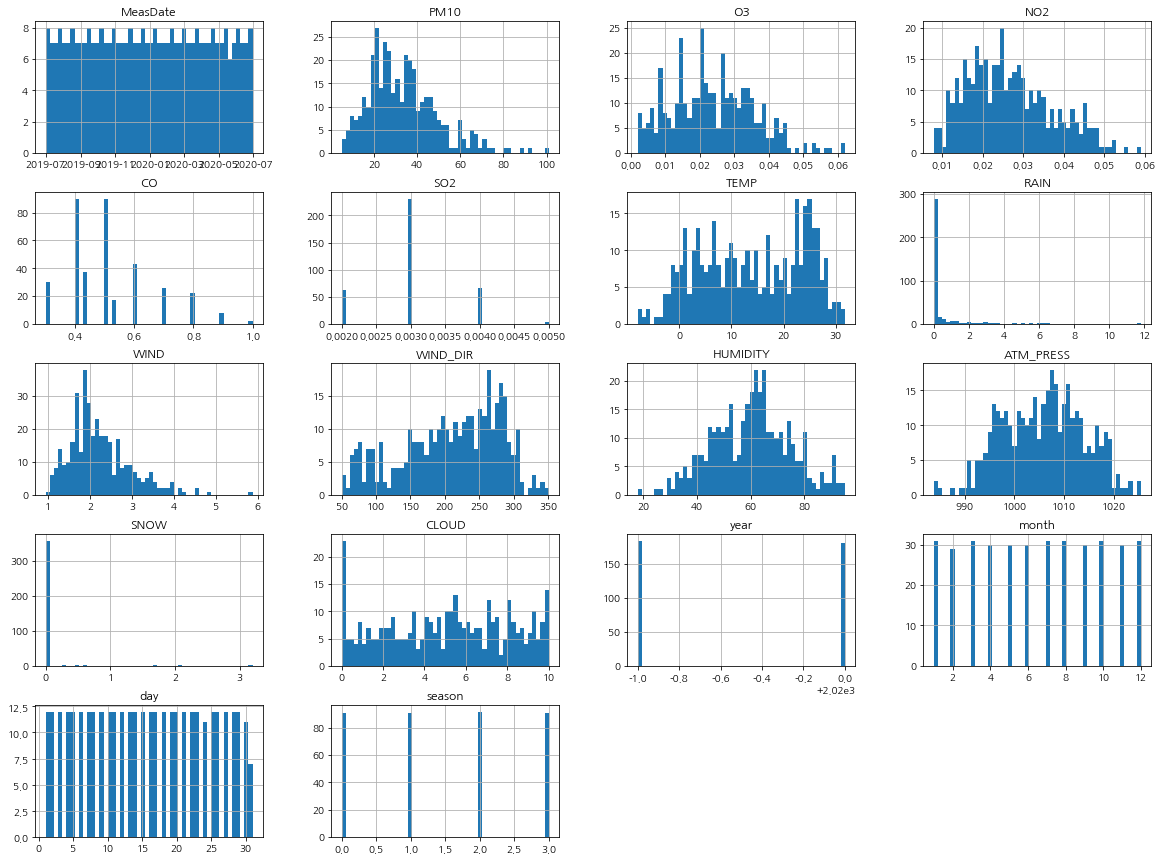

In [59]:
df_raw.hist(bins=50, figsize=(20,15)) #bins: 구간 경곗값

설명변수를 크게 두 가지로 group화 하였다.
- 대기변수: TEMP, RAIN, WIND, WIND_DIR, HUMIDITY, ATM_PRESS, SNOW, CLOUD
- 기상변수: O3, NO2, CO, SO2

In [60]:
df_at = df_raw[["PM10", "O3", "NO2", "CO", "SO2"]] # atmosphere 대기변수 
df_tem = df_raw[["PM10", "TEMP", "RAIN", "WIND", "WIND_DIR", "HUMIDITY", "ATM_PRESS", "SNOW", "CLOUD"]] # temp 기상변수

<AxesSubplot:>

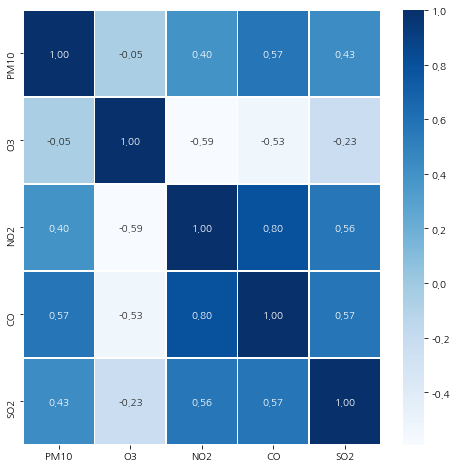

In [61]:
plt.figure(figsize=(8,8))
sns.heatmap(data = df_at.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

대기변수와 미세먼지와의 상관성을 보기 위해 heatmap을 참고하였다.

PM10와 NO2, CO, SO2는 어느 정도 상관성이 있다고 보여진다. 또한, NO2, CO, SO2는 서로 상관성이 보여진다.

<AxesSubplot:>

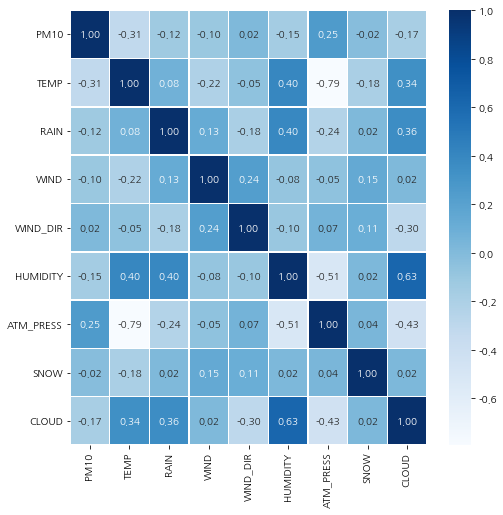

In [62]:
plt.figure(figsize=(8,8))
sns.heatmap(data = df_tem.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

기상변수와 미세먼지와의 상관성을 보기 위해 heatmap을 참고하였다.

대기변수와는 사뭇 다르게 기상변수와 미세먼지간의 뚜렷한 상관성을 보기 어려웠다. 독립변수들 간에는 CLOUD와 HUMIDITY 간에 상관관계가 보인다.

histogram은 구간별 분포 현황과 패턴 및 이상치를 확인할 수 있는 그래프로, 위의 그래프들을 살펴보면, 정규분포와 유사한 패턴을 보이는 미세먼지(PM10), 오존(O3), 이산화질소(NO2), 습도(HUMIDITY), 기압(ATM_PRESS)이 의미가 있어 보인다.

이 중에서 대기오염과 미세먼지와의 관계를 알아보기 위해 PM10과 O3 / NO2 / CO/ SO2 간의 관계를 살펴보고자 한다.

[]

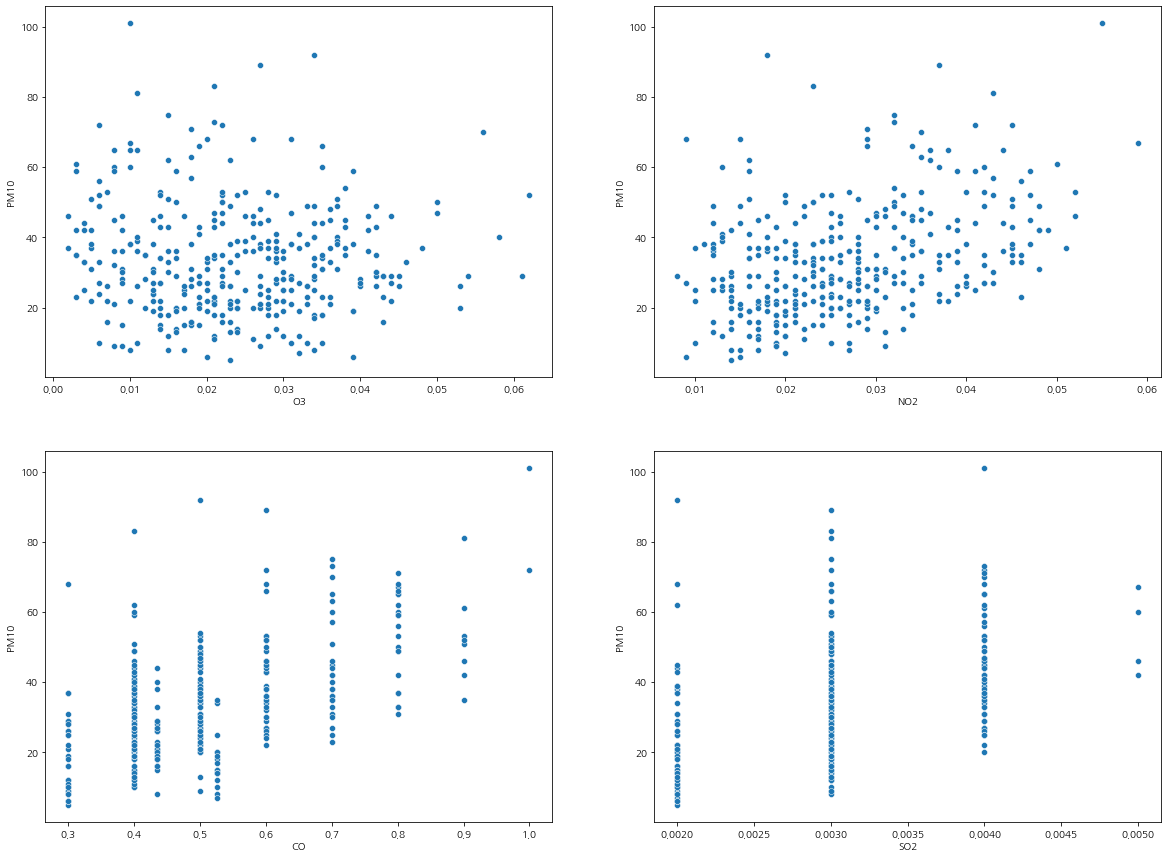

In [63]:
f, ax = plt.subplots(2, 2, figsize=(20,15))
sns.scatterplot(x='O3', y='PM10', data=df_raw, ax=ax[0,0])
sns.scatterplot(x='NO2', y='PM10', data=df_raw, ax=ax[0,1])
sns.scatterplot(x='CO', y='PM10', data=df_raw, ax=ax[1,0])
sns.scatterplot(x='SO2', y='PM10', data=df_raw, ax=ax[1,1])
plt.plot()

위의 그래프들을 통해 미세먼지는 어느 정도 CO, NO2에 영향을 받는 것을 예상해 볼 수 있다. 상관관계를 더 잘 알기위해 이후에 상관분석을 하고자 한다.

[]

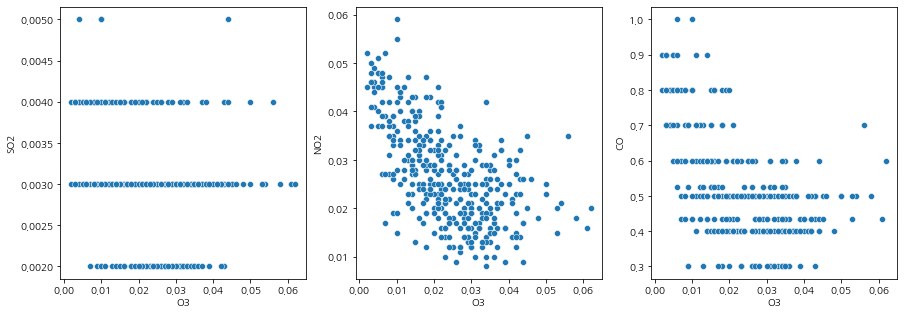

In [64]:
f, ax = plt.subplots(1, 3, figsize=(15,5))
sns.scatterplot(x='O3', y='SO2', data=df_raw, ax=ax[0])
sns.scatterplot(x='O3', y='NO2', data=df_raw, ax=ax[1])
sns.scatterplot(x='O3', y='CO', data=df_raw, ax=ax[2])
plt.plot()

O3는 NO2, CO와 상관관계를 보이며 경향성을 보여주는 것으로 판단된다. 확실한 검정을 위해 차후에 추가적인 검정을 실시하도록 한다.

즉 O3는 대기오염에 직접적인 영향을 주는 것처럼 보이진 않지만 NO2, CO에 영향을 주어 간접적으로 대기오염에 영향을 미치는 것으로 예상할 수 있다.

결론적으로, 대기오염은 시간의 흐름에 따라 상관관계를 갖는다. 시간은 O3의 농도와 상관성이 높으며 O3는 직접적으로 대기오염에 관여하기보다는 NO2, CO와의 화학작용을 통해 간접적으로 대기오염에 영향을 준다고 보여진다.

위의 그래프로 온도와 미세먼지의 무관함을 확인할 수 있다.

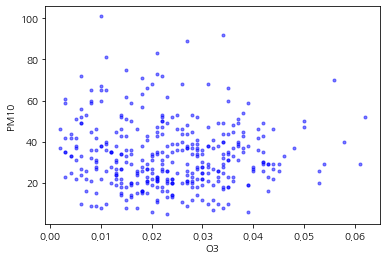

In [65]:
plt.plot('O3', 'PM10', data=df_raw, linestyle='none', marker='o', markersize=3, color='blue', alpha=0.5)
plt.xlabel('O3', fontsize=10)
plt.ylabel('PM10', fontsize=10)
plt.show()

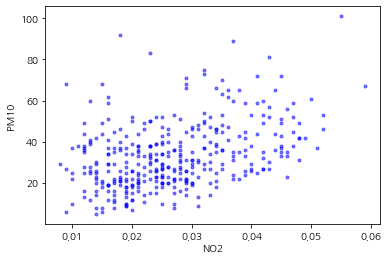

In [66]:
plt.plot('NO2', 'PM10', data=df_raw, linestyle='none', marker='o', markersize=3, color='blue', alpha=0.5)
plt.xlabel('NO2', fontsize=10)
plt.ylabel('PM10', fontsize=10)
plt.show()

PM10과 NO2는 어느정도 상관성을 보인다. 이는 4. 검정 중 '상관분석'에서 자세히 알아보도록 하자.

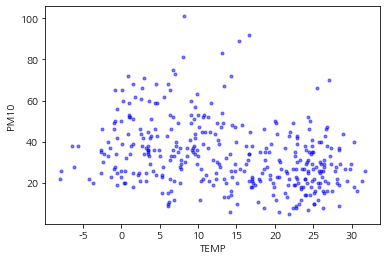

In [67]:
plt.plot('TEMP', 'PM10', data=df_raw, linestyle = 'none', marker = 'o', markersize=3, color = 'blue', alpha=0.5)
plt.xlabel('TEMP', fontsize = 10)
plt.ylabel('PM10', fontsize = 10)
plt.show()

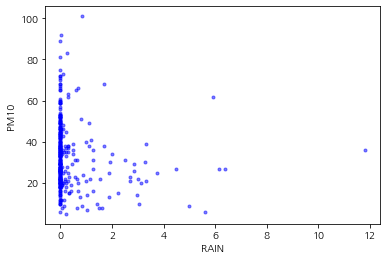

In [68]:
plt.plot('RAIN', 'PM10', data=df_raw, linestyle='none', marker='o', markersize=3, color='blue', alpha=0.5)
plt.xlabel('RAIN', fontsize=10)
plt.ylabel('PM10', fontsize=10)
plt.show()

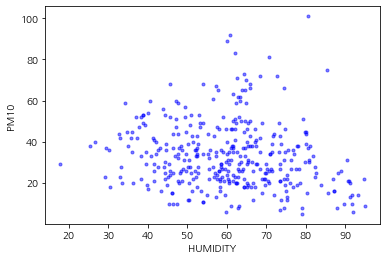

In [69]:
plt.plot('HUMIDITY', 'PM10', data=df_raw, linestyle='none', marker='o', markersize=3, color='blue', alpha=0.5)
plt.xlabel('HUMIDITY', fontsize=10)
plt.ylabel('PM10', fontsize=10)
plt.show()

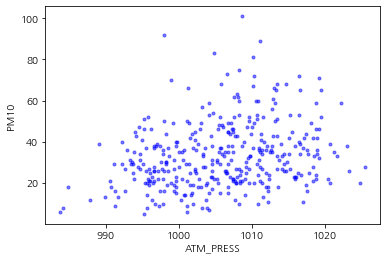

In [70]:
plt.plot('ATM_PRESS', 'PM10', data=df_raw, linestyle='none', marker='o', markersize=3, color='blue', alpha=0.5)
plt.xlabel('ATM_PRESS', fontsize=10)
plt.ylabel('PM10', fontsize=10)
plt.show()

비와 습도는 어느 정도 상관이 있다. 위의 그래프를 보면 미세먼지와 어느 정도 상관성이 있어보이는데, 정확한 분석을 위해서는 검정을 해보기로 한다.

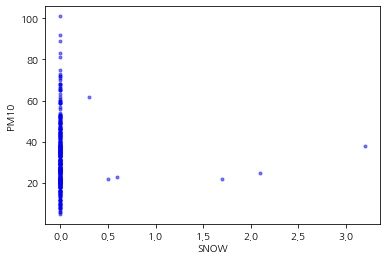

In [71]:
plt.plot('SNOW', 'PM10', data=df_raw, linestyle='none', marker='o', markersize=3, color='blue', alpha=0.5)
plt.xlabel('SNOW', fontsize=10)
plt.ylabel('PM10', fontsize=10)
plt.show()

#### 3) 시간의 흐름에 따른 추세

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '2019-07'),
  Text(1, 0, '2019-08'),
  Text(2, 0, '2019-09'),
  Text(3, 0, '2019-10'),
  Text(4, 0, '2019-11'),
  Text(5, 0, '2019-12'),
  Text(6, 0, '2020-01'),
  Text(7, 0, '2020-02'),
  Text(8, 0, '2020-03'),
  Text(9, 0, '2020-04'),
  Text(10, 0, '2020-05'),
  Text(11, 0, '2020-06')])

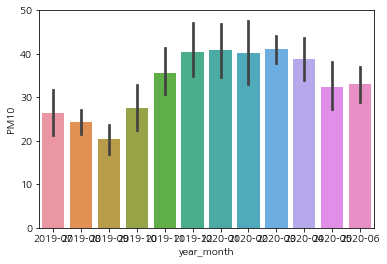

In [72]:
graph1 = sns.barplot(x='year_month', y='PM10', data=df_raw)
plt.xticks(rotation=0)

더 정확한 비교를 위해 년도와 월별을 함께 고려해보아 그래프를 출력하면, 겨울에 특히 미세먼지 농도가 높은 사실을 알 수 있다.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '2019-07'),
  Text(1, 0, '2019-08'),
  Text(2, 0, '2019-09'),
  Text(3, 0, '2019-10'),
  Text(4, 0, '2019-11'),
  Text(5, 0, '2019-12'),
  Text(6, 0, '2020-01'),
  Text(7, 0, '2020-02'),
  Text(8, 0, '2020-03'),
  Text(9, 0, '2020-04'),
  Text(10, 0, '2020-05'),
  Text(11, 0, '2020-06')])

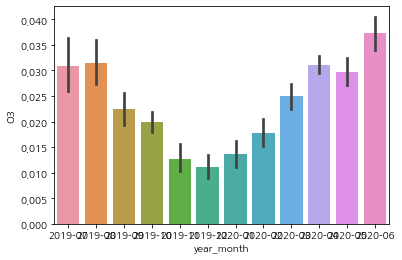

In [73]:
graph1 = sns.barplot(x='year_month', y='O3', data=df_raw)
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '2019-07'),
  Text(1, 0, '2019-08'),
  Text(2, 0, '2019-09'),
  Text(3, 0, '2019-10'),
  Text(4, 0, '2019-11'),
  Text(5, 0, '2019-12'),
  Text(6, 0, '2020-01'),
  Text(7, 0, '2020-02'),
  Text(8, 0, '2020-03'),
  Text(9, 0, '2020-04'),
  Text(10, 0, '2020-05'),
  Text(11, 0, '2020-06')])

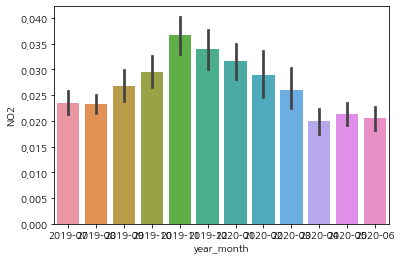

In [74]:
graph1 = sns.barplot(x='year_month', y='NO2', data=df_raw)
plt.xticks(rotation=0)

계절에 따른 PM10 비교

array([[<AxesSubplot:title={'center':'PM10'}>]], dtype=object)

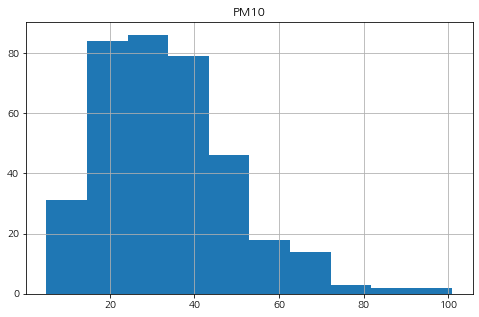

In [75]:
df_raw.hist('PM10', figsize=(8,5))

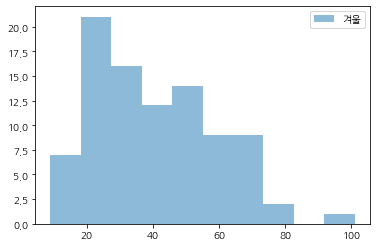

In [76]:
plt.hist(df_raw[df_raw["season"]==0]["PM10"], label ='겨울', alpha = 0.5)
plt.legend()

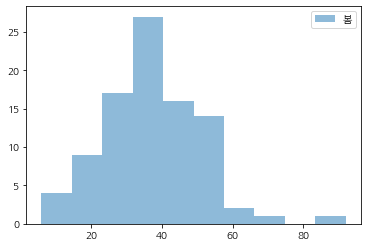

In [77]:
plt.hist(df_raw[df_raw["season"]==1]["PM10"], label ='봄', alpha = 0.5)
plt.legend()

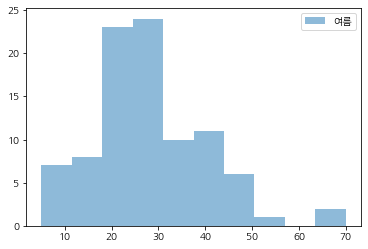

In [78]:
plt.hist(df_raw[df_raw["season"]==2]["PM10"], label ='여름', alpha = 0.5)
plt.legend()

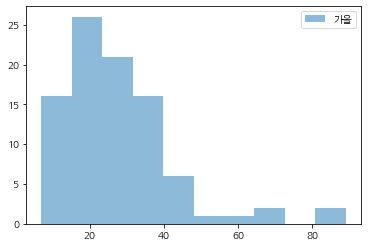

In [79]:
plt.hist(df_raw[df_raw["season"]==3]["PM10"], label ='가을', alpha = 0.5)
plt.legend()

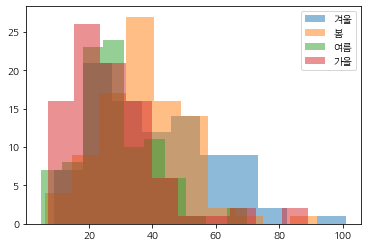

In [80]:
plt.hist(df_raw[df_raw["season"]==0]["PM10"], label ='겨울', alpha = 0.5)
plt.hist(df_raw[df_raw["season"]==1]["PM10"], label ='봄', alpha = 0.5)
plt.hist(df_raw[df_raw["season"]==2]["PM10"], label ='여름', alpha = 0.5)
plt.hist(df_raw[df_raw["season"]==3]["PM10"], label ='가을', alpha = 0.5)
plt.legend()

#### 4) 풍향에 따른 상관관계

<AxesSubplot:xlabel='ATM_PRESS', ylabel='PM10'>

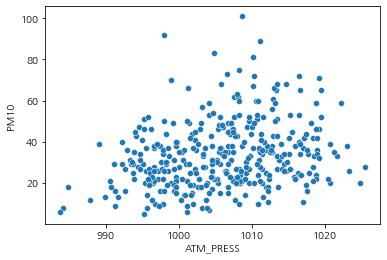

In [81]:
sns.scatterplot(x="ATM_PRESS", y="PM10", data=df_raw)

<AxesSubplot:title={'center':'PM10'}, xlabel='[WIND_DIR_1]'>

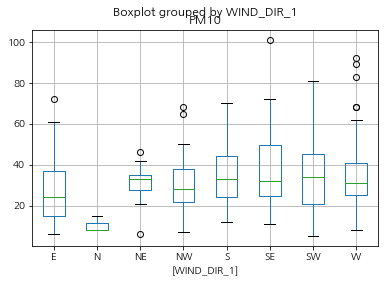

In [82]:
df_raw.boxplot(column="PM10", by =["WIND_DIR_1"])

기상변수는 서로 영향을 미치기 때문에 복합적으로 고려해야겠지만 단순하게 풍향과 미세먼지와의 관계를 보았을 때, 유독 서풍에서의 이상치가 많았다.또한 남서풍의 경우에도 다른 풍향보다도 PM10 수치가 높은 경우가 많은 것을 알 수 있다.

In [83]:
df_raw[(df_raw["WIND_DIR_1"] == 'W') & (df_raw["PM10"] > 60)]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,...,month,day,year_month,season,계절,PM10_상세,WIND_DIR_1,WIND_STR,SNOW1,RAIN1
120,2019-10-29,83.0,0.021,0.023,0.4,0.003,13.05,0.25,2.40,286,...,10,29,2019-10,3,가을,매우_나쁨,W,중간,0,1
123,2019-11-01,89.0,0.027,0.037,0.6,0.003,15.30,0.00,1.80,256,...,11,1,2019-11,3,가을,매우_나쁨,W,중간,0,0
140,2019-11-18,62.0,0.023,0.016,0.4,0.002,5.53,5.93,3.65,280,...,11,18,2019-11,3,가을,나쁨,W,강함,0,1
216,2020-02-02,68.0,0.020,0.029,0.8,0.004,1.48,0.00,1.79,278,...,2,2,2020-02,0,겨울,나쁨,W,중간,0,0
236,2020-02-22,68.0,0.031,0.015,0.6,0.003,4.50,1.68,3.97,268,...,2,22,2020-02,0,겨울,나쁨,W,강함,0,1
315,2020-05-11,92.0,0.034,0.018,0.5,0.002,16.65,0.03,2.96,276,...,5,11,2020-05,1,봄,매우_나쁨,W,중간,0,1


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'W'),
  Text(1, 0, 'S'),
  Text(2, 0, 'E'),
  Text(3, 0, 'SW'),
  Text(4, 0, 'SE'),
  Text(5, 0, 'NE'),
  Text(6, 0, 'N'),
  Text(7, 0, 'NW')])

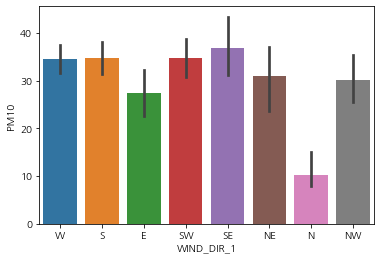

In [84]:
graph1 = sns.barplot(x='WIND_DIR_1', y='PM10', data=df_raw)
plt.xticks(rotation=0)

<AxesSubplot:xlabel='PM10_상세', ylabel='count'>

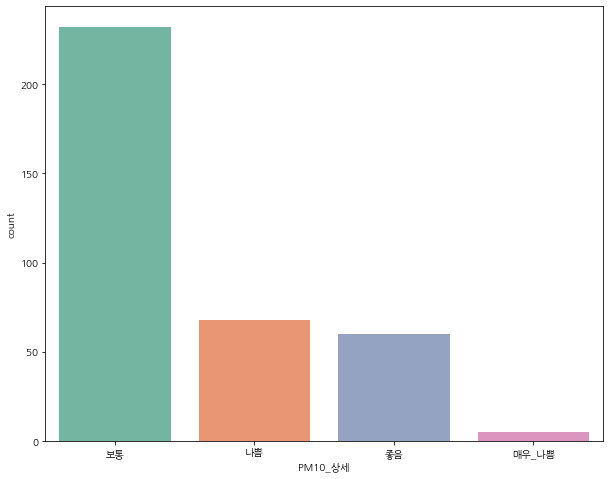

In [85]:
plt.figure(figsize=(10, 8))
sns.countplot(data=df_raw, x='PM10_상세', order=df_raw['PM10_상세'].value_counts().index,
              palette='Set2')

**PM10 이 '나쁨'인 경우, WIND_DIR_1 살펴보기**

In [86]:
df1 = df_raw.loc[(df_raw['PM10_상세'] == '매우_나쁨')]
df1.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,...,month,day,year_month,season,계절,PM10_상세,WIND_DIR_1,WIND_STR,SNOW1,RAIN1
120,2019-10-29,83.0,0.021,0.023,0.4,0.003,13.05,0.25,2.40,286,...,10,29,2019-10,3,가을,매우_나쁨,W,중간,0,1
123,2019-11-01,89.0,0.027,0.037,0.6,0.003,15.30,0.00,1.80,256,...,11,1,2019-11,3,가을,매우_나쁨,W,중간,0,0
162,2019-12-10,101.0,0.010,0.055,1.0,0.004,8.12,0.85,1.22,148,...,12,10,2019-12,0,겨울,매우_나쁨,SE,약함,0,1
228,2020-02-14,81.0,0.011,0.043,0.9,0.003,7.99,0.00,1.20,210,...,2,14,2020-02,0,겨울,매우_나쁨,SW,약함,0,0
315,2020-05-11,92.0,0.034,0.018,0.5,0.002,16.65,0.03,2.96,276,...,5,11,2020-05,1,봄,매우_나쁨,W,중간,0,1


<AxesSubplot:ylabel='None'>

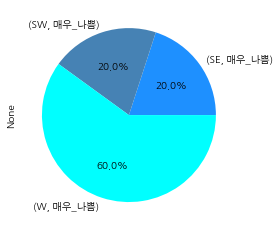

In [87]:
df_count = df1.groupby(["WIND_DIR_1", "PM10_상세"]).size()
colors = ['dodgerblue', 'steelblue', 'cyan', 'paleturquoise']

df_count.plot.pie(y="PM10", autopct="%.1f%%", colors = colors)

pie chart를 이용해 미세먼지 수치가 '매우 나쁨'인 경우 서풍과 남서풍의 비중이 80%나 된다.

**PM10 이 '나쁨'인 경우, WIND_DIR_1 살펴보기**

In [88]:
df2 = df_raw.loc[(df_raw['PM10_상세'] == '나쁨')]
df2.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,...,month,day,year_month,season,계절,PM10_상세,WIND_DIR_1,WIND_STR,SNOW1,RAIN1
16,2019-07-17,66.0,0.035,0.029,0.6,0.003,25.54,0.70,1.18,189,...,7,17,2019-07,2,여름,나쁨,S,약함,0,1
17,2019-07-18,70.0,0.056,0.035,0.7,0.004,27.04,0.00,1.12,192,...,7,18,2019-07,2,여름,나쁨,S,약함,0,0
21,2019-07-22,46.0,0.041,0.022,0.4,0.003,26.68,0.03,2.13,230,...,7,22,2019-07,2,여름,나쁨,SW,중간,0,1
91,2019-09-30,49.0,0.034,0.042,0.6,0.003,22.41,0.00,1.51,281,...,9,30,2019-09,3,가을,나쁨,W,중간,0,0
122,2019-10-31,72.0,0.022,0.041,0.6,0.004,14.23,0.00,2.21,138,...,10,31,2019-10,3,가을,나쁨,SE,중간,0,0


<AxesSubplot:ylabel='None'>

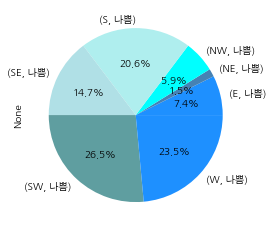

In [89]:
df_count = df2.groupby(["WIND_DIR_1", "PM10_상세"]).size()
colors = ['dodgerblue', 'steelblue', 'cyan', 'paleturquoise', 'powderblue', 'cadetblue']

df_count.plot.pie(y="PM10", autopct="%.1f%%", colors=colors)

pie chart를 이용해 미세먼지 수치가 '나쁨'인 경우 많은 비중을 차지하는 풍향은 서풍과 남서풍으로 이 둘을 합하면 비중이 50%나 된다.

의미 있는 범주인 '매우 나쁨'과 '나쁨'인 경우 과반수가 W, SW 쪽에서 오는 것을 알 수 있다.

추가적으로 기압, 풍속도 주요한 요인이기에 이들을 조합한 결과를 보아야 더 확실해질 것 같다.

<AxesSubplot:xlabel='WIND', ylabel='ATM_PRESS'>

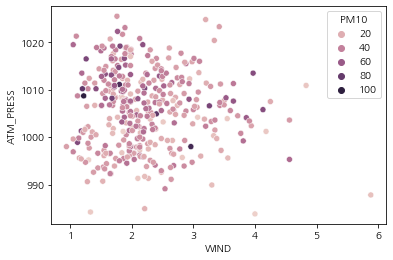

In [90]:
sns.scatterplot(x="WIND", y="ATM_PRESS", hue="PM10", data=df_raw)

<AxesSubplot:xlabel='WIND_DIR', ylabel='ATM_PRESS'>

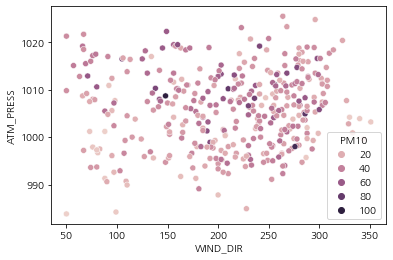

In [91]:
sns.scatterplot(x="WIND_DIR", y="ATM_PRESS", hue="PM10", data=df_raw)

풍향과 기압은 어느 정도 상관성이 있다고 예측되어진다. 이는 아래의 검정 파트에서 상관분석을 실시하고자 한다.

#### 5) 풍속과 풍향

<AxesSubplot:>

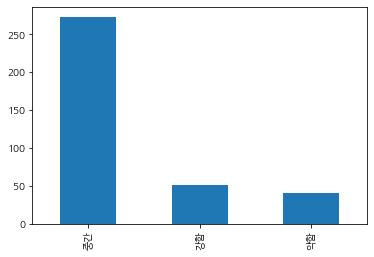

In [92]:
df_count = df_raw["WIND_STR"].value_counts()
df_count.plot.bar()

In [93]:
df_raw.value_counts('WIND_STR')

WIND_STR
중간    273
강함     51
약함     41
dtype: int64

In [94]:
df3 = df_raw.loc[(df_raw['WIND_STR'] == '강함')]

<AxesSubplot:ylabel='None'>

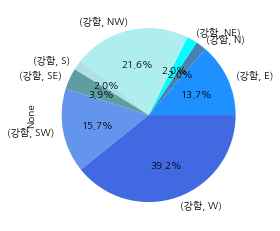

In [95]:
df3_count = df3.groupby(["WIND_STR", "WIND_DIR_1"]).size()
colors = ['dodgerblue', 'steelblue', 'cyan', 'paleturquoise', 'powderblue', 'cadetblue', 'cornflowerblue', 'royalblue', 'darkblue']
df3_count.plot.pie(y="", autopct="%.1f%%", colors=colors)

<AxesSubplot:title={'center':'PM10'}, xlabel='[WIND_STR, WIND_DIR_1]'>

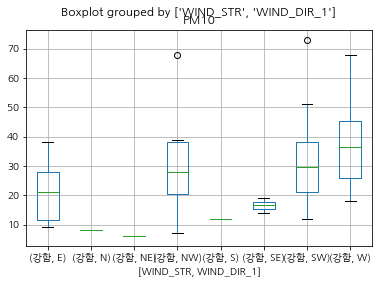

In [96]:
df3.boxplot(column="PM10", by = ["WIND_STR", "WIND_DIR_1"])

In [97]:
df4 = df_raw.loc[(df_raw['WIND_STR'] == '중간')]

<AxesSubplot:ylabel='None'>

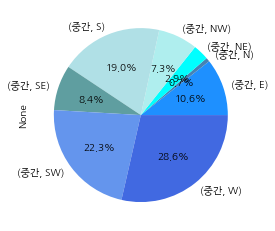

In [98]:
df4_count = df4.groupby(["WIND_STR", "WIND_DIR_1"]).size()
colors = ['dodgerblue', 'steelblue', 'cyan', 'paleturquoise', 'powderblue', 'cadetblue', 'cornflowerblue', 'royalblue', 'darkblue']
df4_count.plot.pie(y="", autopct="%.1f%%", colors=colors)

<AxesSubplot:title={'center':'PM10'}, xlabel='[WIND_STR, WIND_DIR_1]'>

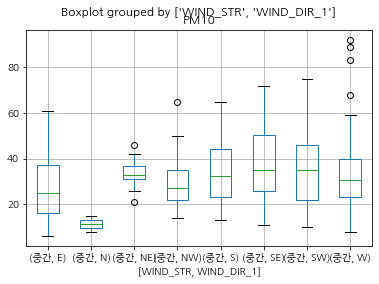

In [99]:
df4.boxplot(column="PM10", by = ["WIND_STR", "WIND_DIR_1"])

In [100]:
df5 = df_raw.loc[(df_raw['WIND_STR'] == '약함')]

<AxesSubplot:ylabel='None'>

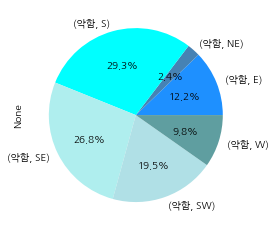

In [101]:
dy>
		<div style="background-color:cyan">구역1</div>
		<div style="width:100px; heidf5_count = df5.groupby(["WIND_STR", "WIND_DIR_1"]).size()
colors = ['dodgerblue', 'steelblue', 'cyan', 'paleturquoise', 'powderblue', 'cadetblue', 'cornflowerblue', 'royalblue', 'darkblue']
df5_count.plot.pie(y="", autopct="%.1f%%", colors=colors)

<AxesSubplot:title={'center':'PM10'}, xlabel='[WIND_STR, WIND_DIR_1]'>

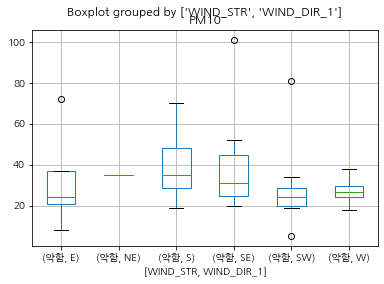

In [102]:
df5.boxplot(column="PM10", by = ["WIND_STR", "WIND_DIR_1"])

In [104]:
df_raw.corr()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,year,month,day,season
PM10,1.000000,-0.051763,0.395969,0.573036,0.428685,-0.309786,-0.121444,-0.100323,0.019949,-0.149803,0.253023,-0.020007,-0.172230,0.274266,-0.201365,-0.071430,-0.336656
O3,-0.051763,1.000000,-0.591658,-0.529021,-0.234127,0.516257,-0.103903,0.165216,0.268680,-0.037699,-0.534372,0.003900,-0.119307,0.179153,-0.156888,0.013482,0.164829
NO2,0.395969,-0.591658,1.000000,0.795099,0.563432,-0.237406,0.029298,-0.536649,-0.408342,-0.065514,0.420292,-0.120893,0.016722,-0.202632,0.190823,-0.002154,-0.017916
CO,0.573036,-0.529021,0.795099,1.000000,0.573881,-0.410822,0.006919,-0.362918,-0.285567,0.015400,0.441847,-0.049635,0.015369,-0.043809,0.051230,-0.069069,-0.253982
SO2,0.428685,-0.234127,0.563432,0.573881,1.000000,-0.273629,-0.128750,-0.252864,-0.093200,-0.302278,0.333995,-0.102927,-0.191234,0.026455,0.003498,0.024703,-0.112702
TEMP,-0.309786,0.516257,-0.237406,-0.410822,-0.273629,1.000000,0.077361,-0.216042,-0.050394,0.404147,-0.792079,-0.184503,0.341553,-0.309993,0.232859,0.009437,0.621268
RAIN,-0.121444,-0.103903,0.029298,0.006919,-0.128750,0.077361,1.000000,0.125901,-0.183431,0.396637,-0.235577,0.019391,0.357903,-0.103493,0.083273,0.008451,0.092341
WIND,-0.100323,0.165216,-0.536649,-0.362918,-0.252864,-0.216042,0.125901,1.000000,0.235237,-0.084299,-0.053769,0.145803,0.016841,0.305982,-0.188682,0.013984,-0.133340
WIND_DIR,0.019949,0.268680,-0.408342,-0.285567,-0.093200,-0.050394,-0.183431,0.235237,1.000000,-0.098825,0.067591,0.108013,-0.296964,0.062941,-0.020444,-0.115534,0.119979
HUMIDITY,-0.149803,-0.037699,-0.065514,0.015400,-0.302278,0.404147,0.396637,-0.084299,-0.098825,1.000000,-0.510358,0.021658,0.627970,-0.200765,0.167530,-0.007805,0.204560


일반적으로 heatmap의 경우 0.7 이상은 강한 상관관계, 0.3이상은 약한 상관관계를 가진다고 할 수 있다.

PM10과의 상관성을 보자면,

- 절대값이 0.3 이상인 약한 '양'의 상관관계: NO2, CO, SO2
- 절대값이 0.3 이상인 약한 '음'의 상관관계: TEMP

풍향 / NO2, CO, SO2 관계성

<AxesSubplot:title={'center':'NO2'}, xlabel='[WIND_DIR_1]'>

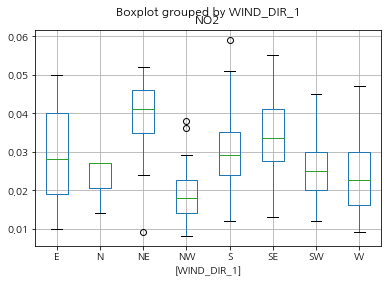

In [105]:
df_raw.boxplot(column="NO2", by  = ["WIND_DIR_1"])

<AxesSubplot:title={'center':'CO'}, xlabel='[WIND_DIR_1]'>

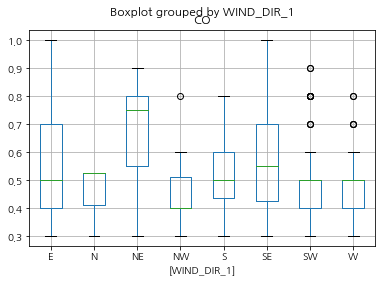

In [106]:
df_raw.boxplot(column="CO", by  = ["WIND_DIR_1"])

<AxesSubplot:title={'center':'SO2'}, xlabel='[WIND_DIR_1]'>

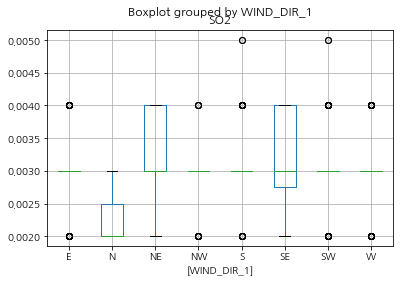

In [107]:
df_raw.boxplot(column="SO2", by  = ["WIND_DIR_1"])

외부요인을 분석하기 위해서 (가설: 풍향이 강할수록 외부에서로 오는 유입 미세먼지가 많을 것이다)

In [108]:
df_raw_h1 = df_raw.loc[(df_raw['WIND_DIR_1']=='N')]

<AxesSubplot:xlabel='WIND', ylabel='PM10'>

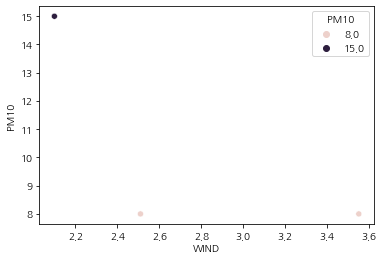

In [109]:
sns.scatterplot(x="WIND", y="PM10", hue="PM10", data=df_raw_h1)

<AxesSubplot:xlabel='WIND', ylabel='NO2'>

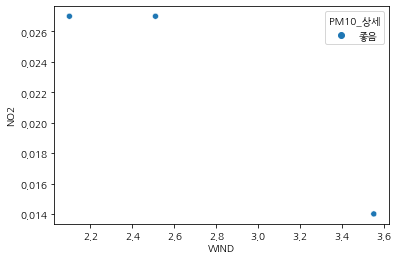

In [110]:
sns.scatterplot(x="WIND", y="NO2", hue="PM10_상세", data=df_raw_h1)

<AxesSubplot:xlabel='WIND', ylabel='CO'>

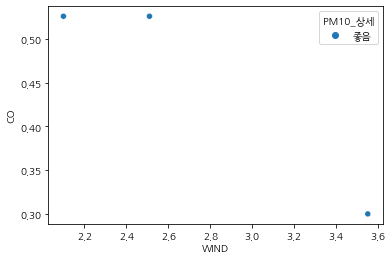

In [111]:
sns.scatterplot(x="WIND", y="CO", hue="PM10_상세", data=df_raw_h1)

<AxesSubplot:xlabel='WIND', ylabel='SO2'>

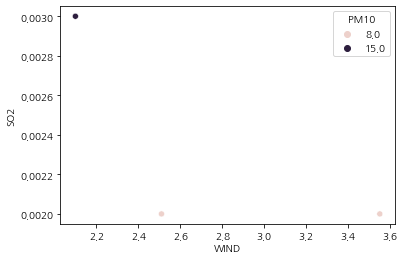

In [112]:
sns.scatterplot(x="WIND", y="SO2", hue="PM10", data=df_raw_h1)

In [113]:
df_raw_h2 = df_raw.loc[(df_raw['WIND_DIR_1']=='NE')]

<AxesSubplot:xlabel='WIND', ylabel='PM10'>

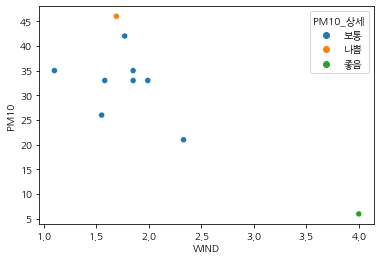

In [114]:
sns.scatterplot(x="WIND", y="PM10", hue="PM10_상세", data=df_raw_h2)

<AxesSubplot:xlabel='WIND', ylabel='NO2'>

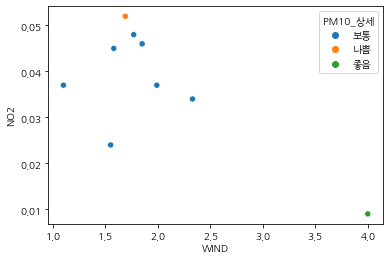

In [115]:
sns.scatterplot(x="WIND", y="NO2", hue="PM10_상세", data=df_raw_h2)

<AxesSubplot:xlabel='WIND', ylabel='CO'>

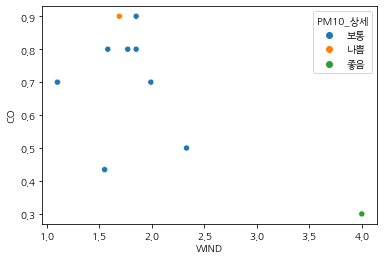

In [116]:
sns.scatterplot(x="WIND", y="CO", hue="PM10_상세", data=df_raw_h2)

<AxesSubplot:xlabel='WIND', ylabel='SO2'>

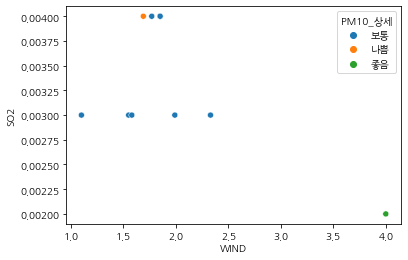

In [117]:
sns.scatterplot(x="WIND", y="SO2", hue="PM10_상세", data=df_raw_h2)

In [118]:
df_raw_h3 = df_raw.loc[(df_raw['WIND_DIR_1']=='E')]

<AxesSubplot:xlabel='WIND', ylabel='PM10'>

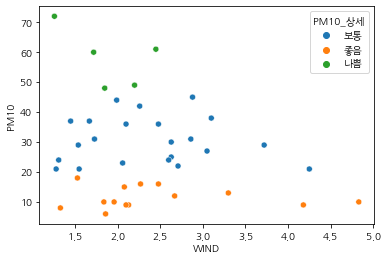

In [119]:
sns.scatterplot(x="WIND", y="PM10", hue="PM10_상세", data=df_raw_h3)

<AxesSubplot:xlabel='WIND', ylabel='NO2'>

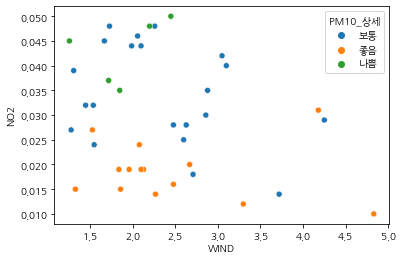

In [120]:
sns.scatterplot(x="WIND", y="NO2", hue="PM10_상세", data=df_raw_h3)

<AxesSubplot:xlabel='WIND', ylabel='CO'>

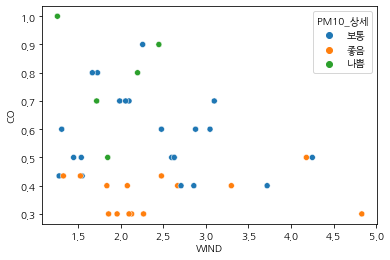

In [121]:
sns.scatterplot(x="WIND", y="CO", hue="PM10_상세", data=df_raw_h3)

<AxesSubplot:xlabel='WIND', ylabel='SO2'>

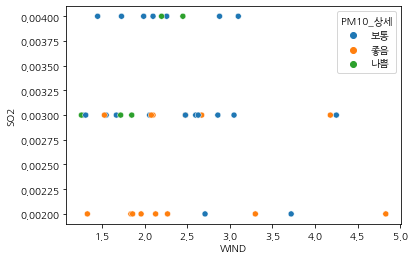

In [122]:
sns.scatterplot(x="WIND", y="SO2", hue="PM10_상세", data=df_raw_h3)

In [123]:
df_raw_h4 = df_raw.loc[(df_raw['WIND_DIR_1']=='SE')]

<AxesSubplot:xlabel='WIND', ylabel='PM10'>

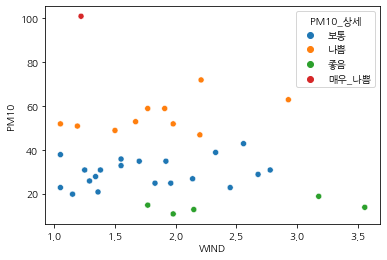

In [124]:
sns.scatterplot(x="WIND", y="PM10", hue="PM10_상세", data=df_raw_h4)

<AxesSubplot:xlabel='WIND', ylabel='NO2'>

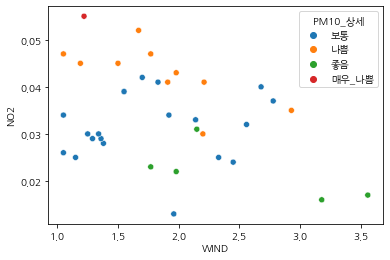

In [125]:
sns.scatterplot(x="WIND", y="NO2", hue="PM10_상세", data=df_raw_h4)

<AxesSubplot:xlabel='WIND', ylabel='CO'>

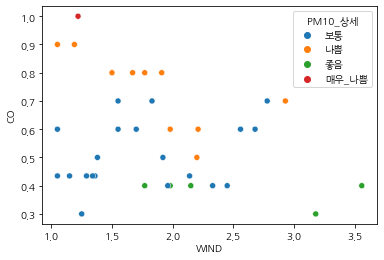

In [126]:
sns.scatterplot(x="WIND", y="CO", hue="PM10_상세", data=df_raw_h4)

<AxesSubplot:xlabel='WIND', ylabel='SO2'>

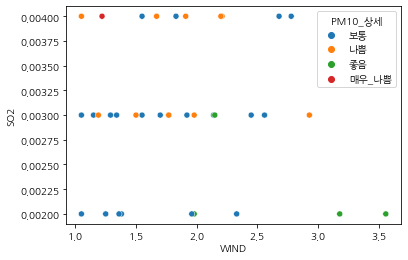

In [127]:
sns.scatterplot(x="WIND", y="SO2", hue="PM10_상세", data=df_raw_h4)

In [128]:
df_raw_h4 = df_raw.loc[(df_raw['WIND_DIR_1']=='S')]

<AxesSubplot:xlabel='WIND', ylabel='PM10'>

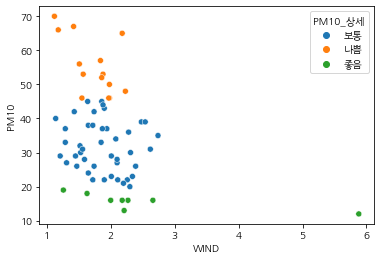

In [129]:
sns.scatterplot(x="WIND", y="PM10", hue="PM10_상세", data=df_raw_h4)

<AxesSubplot:xlabel='WIND', ylabel='NO2'>

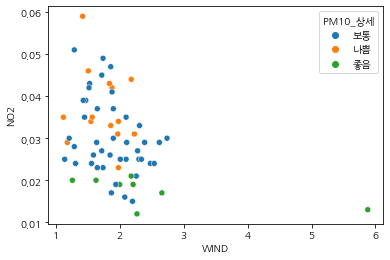

In [130]:
sns.scatterplot(x="WIND", y="NO2", hue="PM10_상세", data=df_raw_h4)

<AxesSubplot:xlabel='WIND', ylabel='CO'>

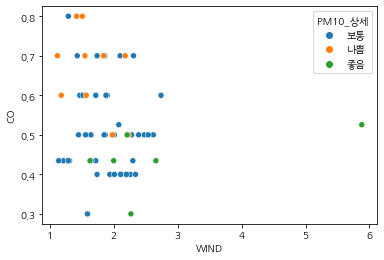

In [131]:
sns.scatterplot(x="WIND", y="CO", hue="PM10_상세", data=df_raw_h4)

<AxesSubplot:xlabel='WIND', ylabel='SO2'>

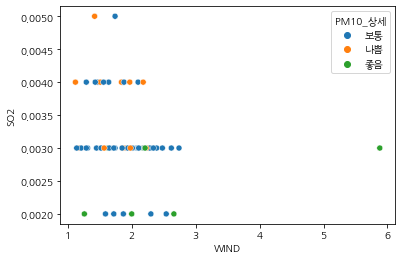

In [132]:
sns.scatterplot(x="WIND", y="SO2", hue="PM10_상세", data=df_raw_h4)

In [133]:
df_raw_h4 = df_raw.loc[(df_raw['WIND_DIR_1']=='SW')]

<AxesSubplot:xlabel='WIND', ylabel='PM10'>

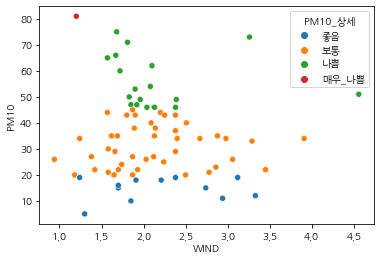

In [134]:
sns.scatterplot(x="WIND", y="PM10", hue="PM10_상세", data=df_raw_h4)

<AxesSubplot:xlabel='WIND', ylabel='NO2'>

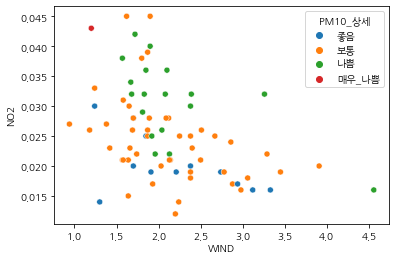

In [135]:
sns.scatterplot(x="WIND", y="NO2", hue="PM10_상세", data=df_raw_h4)

<AxesSubplot:xlabel='WIND', ylabel='CO'>

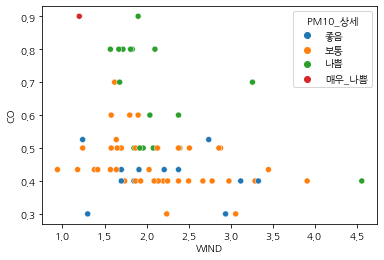

In [136]:
sns.scatterplot(x="WIND", y="CO", hue="PM10_상세", data=df_raw_h4)

<AxesSubplot:xlabel='WIND', ylabel='SO2'>

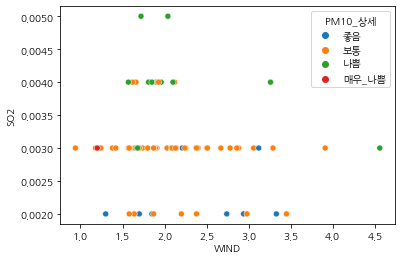

In [137]:
sns.scatterplot(x="WIND", y="SO2", hue="PM10_상세", data=df_raw_h4)

In [138]:
df_raw_h5 = df_raw.loc[(df_raw['WIND_DIR_1']=='W')]

<AxesSubplot:xlabel='WIND', ylabel='PM10'>

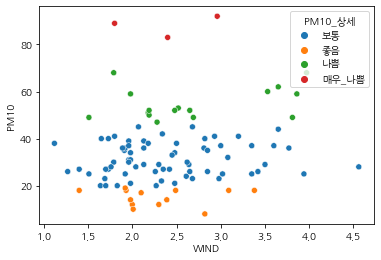

In [139]:
sns.scatterplot(x="WIND", y="PM10", hue="PM10_상세", data=df_raw_h5)

<AxesSubplot:xlabel='WIND', ylabel='NO2'>

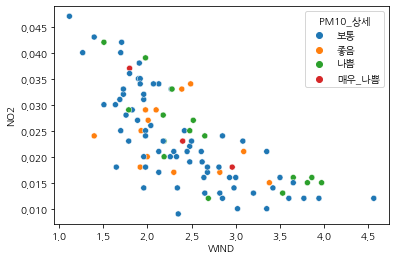

In [140]:
sns.scatterplot(x="WIND", y="NO2", hue="PM10_상세", data=df_raw_h5)

<AxesSubplot:xlabel='WIND', ylabel='CO'>

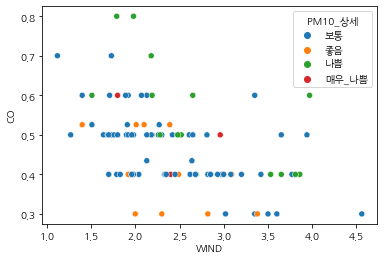

In [141]:
sns.scatterplot(x="WIND", y="CO", hue="PM10_상세", data=df_raw_h5)

<AxesSubplot:xlabel='WIND', ylabel='SO2'>

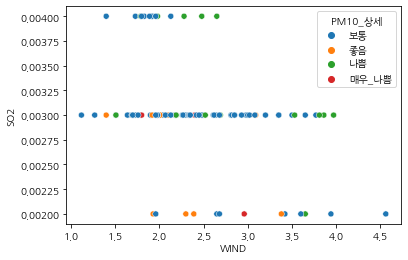

In [142]:
sns.scatterplot(x="WIND", y="SO2", hue="PM10_상세", data=df_raw_h5)

In [143]:
df_raw_h6 = df_raw.loc[(df_raw['WIND_DIR_1']=='NW')]

<AxesSubplot:xlabel='WIND', ylabel='PM10'>

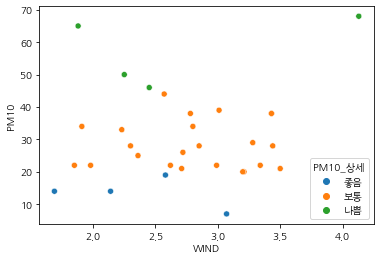

In [144]:
sns.scatterplot(x="WIND", y="PM10", hue="PM10_상세", data=df_raw_h6)

<AxesSubplot:xlabel='WIND', ylabel='NO2'>

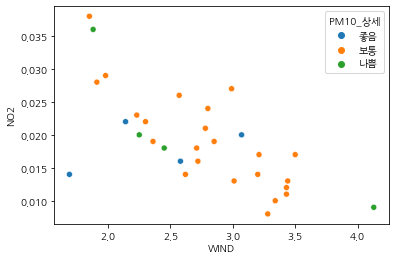

In [145]:
sns.scatterplot(x="WIND", y="NO2", hue="PM10_상세", data=df_raw_h6)

<AxesSubplot:xlabel='WIND', ylabel='CO'>

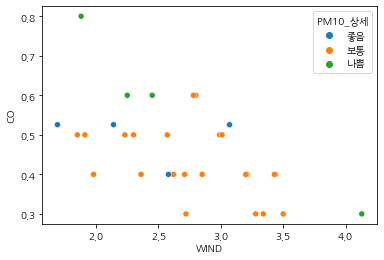

In [146]:
sns.scatterplot(x="WIND", y="CO", hue="PM10_상세", data=df_raw_h6)

<AxesSubplot:xlabel='WIND', ylabel='SO2'>

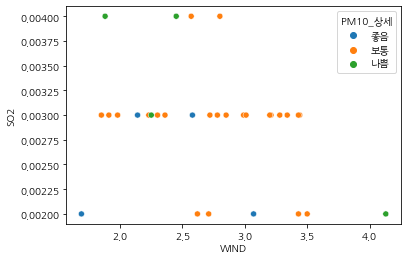

In [147]:
sns.scatterplot(x="WIND", y="SO2", hue="PM10_상세", data=df_raw_h6)

## 4. 검정

### 1)상관분석

위에서 그래프로만 확인했던 각 변수 간의 상관관계를 상관분석을 통해 수치화하여 알아보고자 한다.

In [150]:
def corr_ana(corr, pval):
    corr, pval = stats.pearsonr(corr, pval)
    print("Correlation Analysis")
    print("corr:{0:0.3f}".format(corr))
    print("p-value:{0:0.3f}".format(pval))

#### PM10

In [151]:
corr_ana(df_raw['PM10'], df_raw["O3"])

Correlation Analysis
corr:-0.052
p-value:0.324


PM10과 O3은 상관성이 있다고 할 수 없다. (H0 채택)

In [152]:
corr_ana(df_raw['PM10'], df_raw["ATM_PRESS"])

Correlation Analysis
corr:0.253
p-value:0.000


PM10과 ATM_PRESS는 상관성이 있다고 할 수 있다. (H0 기각)

In [153]:
corr_ana(df_raw['PM10'], df_raw["NO2"])

Correlation Analysis
corr:0.396
p-value:0.000


PM10과 NO2는 약한 상관성이 있다고 할 수 있다. (H0 기각)

In [154]:
corr_ana(df_raw['PM10'], df_raw["CO"])

Correlation Analysis
corr:0.573
p-value:0.000


PM10과 CO는 상관성이 있다고 할 수 있다. (H0 기각)

In [155]:
corr_ana(df_raw['PM10'], df_raw["SO2"])

Correlation Analysis
corr:0.429
p-value:0.000


PM10과 SO2는 상관성이 있다고 할 수 있다. (H0 기각)

In [156]:
corr_ana(df_raw['PM10'], df_raw["TEMP"])

Correlation Analysis
corr:-0.310
p-value:0.000


PM10과 TEMP는 음의 상관성이 있다고 할 수 있다. (H0 기각)

In [157]:
corr_ana(df_raw['PM10'], df_raw["HUMIDITY"])

Correlation Analysis
corr:-0.150
p-value:0.004


PM10과 HUMIDITY는 상관성이 있다고 할 수 있다. (H0 기각)

In [158]:
corr_ana(df_raw['PM10'], df_raw["ATM_PRESS"])

Correlation Analysis
corr:0.253
p-value:0.000


PM10과 ATM_PRESS는 상관성이 있다고 할 수 있다. (H0 기각)

#### O3

In [159]:
corr_ana(df_raw['O3'], df_raw["NO2"])

Correlation Analysis
corr:-0.592
p-value:0.000


O3과 NO1는 음의 상관성이 있다고 할 수 있다. (H0 기각)

In [160]:
corr_ana(df_raw['O3'], df_raw["CO"])

Correlation Analysis
corr:-0.529
p-value:0.000


O3과 CO는 음의 상관성이 있다고 할 수 있다. (H0 기각)

In [161]:
corr_ana(df_raw['O3'], df_raw["SO2"])

Correlation Analysis
corr:-0.234
p-value:0.000


O3과 SO2는 음의 상관성이 있다고 할 수 있다. (H0 기각)

O3는 NO2, CO와 상관관계를 보이며 경향성을 보여주는 것으로 판단된다. 확실한 검정을 위해 차후에 상관분석을 해보았다.

즉 O3는 대기오염에 직접적인 영향을 주는 것처럼 보이진 않지만 NO2, CO에 영향을 주어 간접적으로 대기오염에 영향을 미치는 것으로 예상할 수 있다.

결론적으로, 대기오염은 시간의 흐름에 따라 상관관계를 갖는다. 시간은 O3의 농도와 상관성이 높으며 O3는 직접적으로 대기오염에 관여하기보다는 NO2, CO와의 화학작용을 통해 간접적으로 대기오염에 영향을 준다고 보여진다.

#### WIND(풍속)

In [162]:
corr_ana(df_raw['WIND'], df_raw["ATM_PRESS"])

Correlation Analysis
corr:-0.054
p-value:0.306


WIND과 ATM_PRESS은 상관성이 있다고 할 수 없다. (H0 채택)

In [163]:
corr_ana(df_raw['WIND_DIR'], df_raw["ATM_PRESS"])

Correlation Analysis
corr:0.068
p-value:0.198


WIND_DIR과 ATM_PRESS은 상관성이 있다고 할 수 없다. (H0 채택)

In [164]:
corr_ana(df_raw['WIND_DIR'], df_raw["WIND"])

Correlation Analysis
corr:0.235
p-value:0.000


WIND_DIR과 WIND은 상관성이 있다고 할 수 있다. (H1 채택)

위에서 설정한 바와 같이
- df_raw_h4: SW
- df_raw_h5: W
- df_raw_h6: NW

In [165]:
corr_ana(df_raw_h4['WIND'], df_raw_h4["PM10"])

Correlation Analysis
corr:-0.033
p-value:0.773


In [166]:
corr_ana(df_raw_h5['WIND'], df_raw_h5["PM10"])

Correlation Analysis
corr:0.173
p-value:0.083


In [167]:
corr_ana(df_raw_h6['WIND'], df_raw_h6["PM10"])

Correlation Analysis
corr:0.113
p-value:0.543


**계절과 기압**

In [168]:
corr_ana(df_raw['season'], df_raw["ATM_PRESS"])

Correlation Analysis
corr:-0.336
p-value:0.000


season과 ATM_PRESS은 상관성이 있다고 할 수 있다. (H1 채택)

### 2) 2-Sample t-Test

**rain 변수 확인하기**

In [171]:
rain_0 = (df_raw.RAIN1 == '0')

df_raw.loc[rain_0,['PM10']]

,PM10
0,29.0
1,26.0
2,30.0
3,28.0
4,29.0
...,...
355,30.0
356,36.0
357,37.0
361,22.0


In [172]:
rain_1 = (df_raw.RAIN1 == '1')

df_raw.loc[rain_1,['PM10']]

,PM10
9,9.0
10,5.0
14,38.0
15,31.0
16,66.0
...,...
358,30.0
359,13.0
360,19.0
363,36.0


In [173]:
t_result = stats.ttest_ind(rain_0, rain_1)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print("2-Sample t-test")
print("t:{}".format(t))
print("p:{}".format(p))

2-Sample t-test
t:11.112
p:0.0


유의수준 5% 검정 결과 P값이 0.0 이므로 비가 오고 안오고에 따라 PM10치가 동일하다고 할 수 있다. 따라서 비의 유무는 미세먼지 예측에 있어 중요한 변수라고 볼 수 없다.

**snow 변수 확인하기**

In [174]:
snow_0 = (df_raw.SNOW1 == '0')

df_raw.loc[snow_0,['PM10']]

,PM10
0,29.0
1,26.0
2,30.0
3,28.0
4,29.0
...,...
360,19.0
361,22.0
362,27.0
363,36.0


In [175]:
snow_1 = (df_raw.SNOW1 == '1')

df_raw.loc[snow_1,['PM10']]

,PM10
202,62.0
218,23.0
219,22.0
230,25.0
231,38.0
232,22.0


In [176]:
t_result = stats.ttest_ind(snow_0, snow_1)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print("2-Sample t-test")
print("t:{}".format(t))
print("p:{}".format(p))

2-Sample t-test
t:102.609
p:0.0


유의수준 5% 검정 결과 P값이 0.0 이므로 눈이 오고 안오고에 따라 PM10치가 동일하다고 할 수 있다. 따라서 눈의 유무는 미세먼지 예측에 있어 중요한 변수라고 볼 수 없다.

<AxesSubplot:title={'center':'CO'}, xlabel='[계절]'>

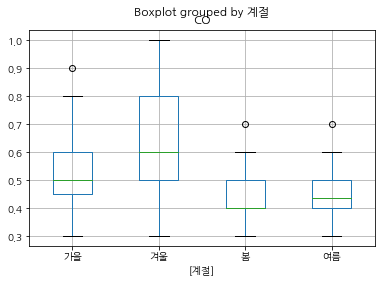

In [177]:
df_raw.boxplot(column="CO", by = ["계절"])

In [178]:
spring = (df_raw.계절 == '봄')

df_raw.loc[spring,['PM10']]

,PM10
244,43.0
245,36.0
246,43.0
247,44.0
248,34.0
...,...
330,19.0
331,27.0
332,31.0
333,33.0


In [179]:
summer = (df_raw.계절 == '여름')

df_raw.loc[summer,['PM10']]

,PM10
0,29.0
1,26.0
2,30.0
3,28.0
4,29.0
...,...
360,19.0
361,22.0
362,27.0
363,36.0


In [180]:
autumn = (df_raw.계절 == '가을')

df_raw.loc[autumn,['PM10']]

,PM10
62,18.0
63,25.0
64,20.0
65,8.0
66,10.0
...,...
148,22.0
149,34.0
150,36.0
151,39.0


In [181]:
winter = (df_raw.계절 == '겨울')

df_raw.loc[winter,['PM10']]

,PM10
153,36.0
154,20.0
155,26.0
156,25.0
157,20.0
...,...
239,21.0
240,16.0
241,11.0
242,24.0


In [182]:
t_result = stats.ttest_ind(spring, summer)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print("2-Sample t-test")
print("t:{}".format(t))
print("p:{}".format(p))

2-Sample t-test
t:-0.085
p:0.932


In [183]:
t_result = stats.ttest_ind(spring, autumn)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print("2-Sample t-test")
print("t:{}".format(t))
print("p:{}".format(p))

2-Sample t-test
t:0.0
p:1.0


In [184]:
t_result = stats.ttest_ind(spring, winter)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print("2-Sample t-test")
print("t:{}".format(t))
print("p:{}".format(p))

2-Sample t-test
t:0.0
p:1.0


In [185]:
t_result = stats.ttest_ind(summer, autumn)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print("2-Sample t-test")
print("t:{}".format(t))
print("p:{}".format(p))

2-Sample t-test
t:0.085
p:0.932


In [186]:
t_result = stats.ttest_ind(summer, winter)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print("2-Sample t-test")
print("t:{}".format(t))
print("p:{}".format(p))

2-Sample t-test
t:0.085
p:0.932


In [187]:
t_result = stats.ttest_ind(autumn, winter)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print("2-Sample t-test")
print("t:{}".format(t))
print("p:{}".format(p))

2-Sample t-test
t:0.0
p:1.0


## 5. 모델링

<실시한 모델링 종류>
- 다중회귀분석
- 의사결정나무
- 랜덤 포레스트
- 그래디언트 부스팅

In [188]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import graphviz
from sklearn.tree import export_graphviz

matplotlib.rc('font', family = 'NanumGothic')
matplotlib.rc('axes', unicode_minus=False)

from matplotlib import rc, font_manager

최종적으로 필요한 설명변수들만 따로 뽑아서 req_data에 저장한다.

In [198]:
req_data2 = df_raw[['PM10', 'NO2', 'CO', 'SO2','TEMP','HUMIDITY','계절','WIND_DIR_1','WIND_STR']]

In [200]:
req_data2

,PM10,NO2,CO,SO2,TEMP,HUMIDITY,계절,WIND_DIR_1,WIND_STR
0,29.0,0.021,0.5,0.003,24.03,63.2,여름,W,중간
1,26.0,0.020,0.5,0.003,24.29,63.2,여름,W,중간
2,30.0,0.023,0.4,0.003,24.18,65.3,여름,W,중간
3,28.0,0.026,0.4,0.003,25.35,58.6,여름,W,중간
4,29.0,0.035,0.5,0.003,27.30,45.5,여름,S,약함
...,...,...,...,...,...,...,...,...,...
360,19.0,0.016,0.4,0.003,21.66,84.0,여름,SW,강함
361,22.0,0.017,0.4,0.004,23.94,69.8,여름,SW,중간
362,27.0,0.009,0.4,0.003,25.03,71.3,여름,W,중간
363,36.0,0.028,0.6,0.003,24.06,75.5,여름,E,중간


### 1) 다중회귀분석

In [201]:
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,...,month,day,year_month,season,계절,PM10_상세,WIND_DIR_1,WIND_STR,SNOW1,RAIN1
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,...,7,1,2019-07,2,여름,보통,W,중간,0,0
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,...,7,2,2019-07,2,여름,보통,W,중간,0,0
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,...,7,3,2019-07,2,여름,보통,W,중간,0,0
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,...,7,4,2019-07,2,여름,보통,W,중간,0,0
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,...,7,5,2019-07,2,여름,보통,S,약함,0,0


위에서 2-sample t-test의 결과 비와 눈의 유무는 미세먼지관련하여 무관하다고 판단하였기 때문에 두 개의 변수는 뺀 아래의 변수들로 구성을 해 보았다.

In [202]:
reg_model = smf.ols(formula = "PM10 ~ O3 + NO2 + CO + SO2 + TEMP + WIND + WIND_DIR + HUMIDITY + ATM_PRESS + CLOUD", data=df_raw)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     34.87
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           5.33e-47
Time:                        08:55:11   Log-Likelihood:                -1402.9
No. Observations:                 365   AIC:                             2828.
Df Residuals:                     354   BIC:                             2871.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    373.7845    160.356      2.331      0.0

유의수준 5%에서 유의하지 않은 SO2, WIND, HUMIDITY, CLOUD는 제거

In [203]:
df_raw_vif = df_raw[['PM10', 'O3', 'NO2', 'CO', 'TEMP', 'WIND_DIR', 'ATM_PRESS']]

제거 후의 독립변수들 간의 상관관계를 파악하기 위해서 다중공선성을 측정한 결과는 다음과 같다.

In [204]:
df_raw_x = df_raw_vif.drop("PM10", axis = 1)
df_raw_x_const = add_constant(df_raw_x)

df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]

# VIF 정렬
df_vif.sort_values("VIF", inplace = True)
df_vif.round(3)

,variable,VIF
5,WIND_DIR,1.355
1,O3,2.052
3,CO,3.293
6,ATM_PRESS,3.526
4,TEMP,3.550
2,NO2,4.251
0,const,54264.520


In [205]:
df_raw_x = df_raw_vif.drop("PM10", axis = 1, inplace = False)
df_raw_y = df_raw_vif["PM10"] 

In [206]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.4, # test 데이터의 비율
                                                                random_state = 1234)  # random state
print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (219, 6)
train data Y size: (219,)
test data X size: (146, 6)
test data Y size: (146,)


일반적으로, 다중공선성 값이 5 이상이면 해당 변수가 다른 변수와 상관관계가 높아 변수의 회귀 계수 추정을 어렵게 하여 위험하며, 10 이상이면 ‘매우위험’이라고 알려져 있다(Tofallis, 2016). 남은 독립변수가 모두 VIF 5 이하로 다중공선성 문제가 없다고 판단하여 이들의 독립변수들로 회귀식을 정의하기로 한다.

In [207]:
reg_model = smf.ols(formula = "PM10 ~ O3 + NO2 + CO + TEMP  + WIND_DIR + ATM_PRESS", data=df_raw)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     57.09
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           2.57e-49
Time:                        08:55:11   Log-Likelihood:                -1405.5
No. Observations:                 365   AIC:                             2825.
Df Residuals:                     358   BIC:                             2852.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    324.1706    140.082      2.314      0.0

회귀분석 이후 잔차가 많이 줄어들수록 R제곱 커진다. 따라서 R제곱이 클수록 설명력이 높다고 할 수 있다. 해당 모델의 경우 R제곱이 0.486로 48.6%의 설명력을 가진다고 할 수 있다. (adjusted R-squared 값은 0.480으로 48%)

Prob(F-statistics)는 모형에 대한 p-value 로 통상 0.05이하인 경우 통계적으로 유의하다고 판단한다. 이 경우 2.57e-49이므로 통계적으로 유의하다고 판단할 수 있다.

최종 모델의 회귀식은 다음과 같다.

y_hat = 324.1706 + 631.5493 O3 + 405.6936 NO2 + 64.4865 CO - 0.6233 TEMP - 0.3461 ATM_PRESS

In [208]:
reg_y_pred = reg_result.predict(df_test_x)

In [209]:
y_pred = reg_model.fit()

In [210]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

In [211]:
df_test_y

156    25.0
310    28.0
97     11.0
134    37.0
7      10.0
       ... 
124    67.0
5      29.0
223    34.0
63     25.0
351    46.0
Name: PM10, Length: 146, dtype: float64

In [212]:
reg_y_pred

156    34.684669
310    26.507074
97     13.091590
134    49.775818
7      14.952443
         ...    
124    53.709247
5      36.818151
223    37.688056
63     35.751492
351    48.698155
Length: 146, dtype: float64

In [213]:
MAPE(df_test_y, reg_y_pred)

31.146956791735402

이때, MAPE 값은 31.15로, 50이하로 매우 합리적인 예측이 되고 있음을 알 수 있다.(Tofallis, 2016)

*(참고)*

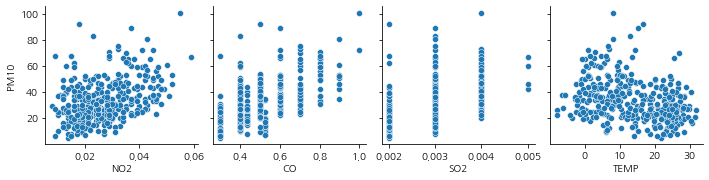

In [214]:
sns.pairplot(df_raw, y_vars="PM10", x_vars=["NO2", "CO", "SO2", "TEMP"])

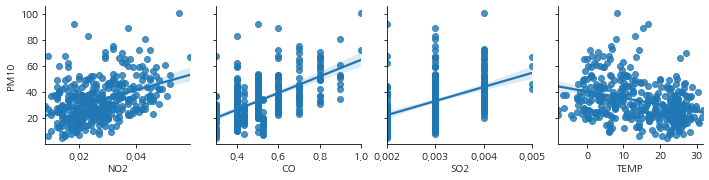

In [215]:
sns.pairplot(df_raw, y_vars="PM10", x_vars=["NO2", "CO", "SO2", "TEMP"], kind="reg")

### 2) 의사결정나무

In [216]:
req_data2 = df_raw[['PM10', 'NO2', 'CO', 'SO2', 'ATM_PRESS','TEMP','HUMIDITY','계절','WIND_DIR_1','WIND_STR']]

In [218]:
req_data2

,PM10,NO2,CO,SO2,ATM_PRESS,TEMP,HUMIDITY,계절,WIND_DIR_1,WIND_STR
0,29.0,0.021,0.5,0.003,995.1,24.03,63.2,여름,W,중간
1,26.0,0.020,0.5,0.003,998.6,24.29,63.2,여름,W,중간
2,30.0,0.023,0.4,0.003,998.3,24.18,65.3,여름,W,중간
3,28.0,0.026,0.4,0.003,996.6,25.35,58.6,여름,W,중간
4,29.0,0.035,0.5,0.003,993.5,27.30,45.5,여름,S,약함
...,...,...,...,...,...,...,...,...,...,...
360,19.0,0.016,0.4,0.003,996.0,21.66,84.0,여름,SW,강함
361,22.0,0.017,0.4,0.004,995.8,23.94,69.8,여름,SW,중간
362,27.0,0.009,0.4,0.003,994.7,25.03,71.3,여름,W,중간
363,36.0,0.028,0.6,0.003,992.9,24.06,75.5,여름,E,중간


In [219]:
df_raw_dummy = pd.get_dummies(req_data2)
df_raw_dummy.head()

,PM10,NO2,CO,SO2,ATM_PRESS,TEMP,HUMIDITY,계절_가을,계절_겨울,계절_봄,...,WIND_DIR_1_N,WIND_DIR_1_NE,WIND_DIR_1_NW,WIND_DIR_1_S,WIND_DIR_1_SE,WIND_DIR_1_SW,WIND_DIR_1_W,WIND_STR_강함,WIND_STR_약함,WIND_STR_중간
0,29.0,0.021,0.5,0.003,995.1,24.03,63.2,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,26.0,0.020,0.5,0.003,998.6,24.29,63.2,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,30.0,0.023,0.4,0.003,998.3,24.18,65.3,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,28.0,0.026,0.4,0.003,996.6,25.35,58.6,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,29.0,0.035,0.5,0.003,993.5,27.30,45.5,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [220]:
df_raw_y = df_raw_dummy["PM10"]
df_raw_x = df_raw_dummy.drop("PM10", axis = 1, inplace = False)

In [221]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.4, random_state = 1234)
print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (219, 21)
train data Y size: (219,)
test data X size: (146, 21)
test data Y size: (146,)


In [222]:
tree_uncustomized = DecisionTreeRegressor(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: 0.197


기본으로 설정된 의사결정나무의 경우 train은 100%인 반면 test는 19.7%로 과소적합하다고 할 수 있다.

In [223]:
tree_uncustomized.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1234,
 'splitter': 'best'}

In [224]:
train_score = []; test_score = []
para_leaf = [n_leaf * 1 for n_leaf in range(1,50)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf = v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSampelsLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

df_score_leaf.round(3)

,MinSampelsLeaf,TrainScore,TestScore
0,1,1.000,0.197
1,2,0.885,0.123
2,3,0.816,0.197
3,4,0.761,0.230
4,5,0.739,0.260
5,6,0.659,0.191
6,7,0.649,0.285
7,8,0.568,0.331
8,9,0.546,0.341
9,10,0.535,0.294


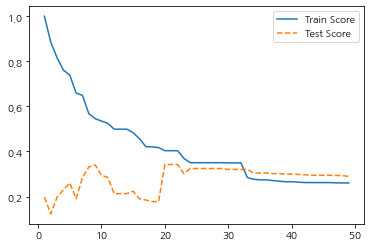

In [225]:
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test Score")
plt.legend()

In [289]:
# v_feature_name = df_train_x.columns
# tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf = 10)
# tree_graph.fit(df_train_x, df_train_y)
# v_feature_name = df_train_x.columns
# fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (4,4), dpi = 300)
# plot_tree(tree_graph, feature_names = v_feature_name, filled = True);

In [227]:
train_score = []; test_score = []
para_split = [n_split * 2 for n_split in range(2,20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=10,min_samples_split = v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TetsScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TetsScore
0,4,0.535,0.294
1,6,0.535,0.294
2,8,0.535,0.294
3,10,0.535,0.294
4,12,0.535,0.294
5,14,0.535,0.294
6,16,0.535,0.294
7,18,0.535,0.294
8,20,0.535,0.294
9,22,0.526,0.284


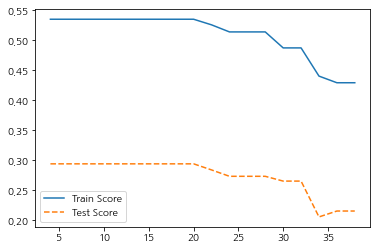

In [228]:
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.legend()

In [229]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=10, min_samples_split=22,max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.202,0.101
1,2,0.312,0.229
2,3,0.421,0.240
3,4,0.454,0.222
4,5,0.492,0.262
5,6,0.526,0.284
6,7,0.526,0.284
7,8,0.526,0.284
8,9,0.526,0.284
9,10,0.526,0.284


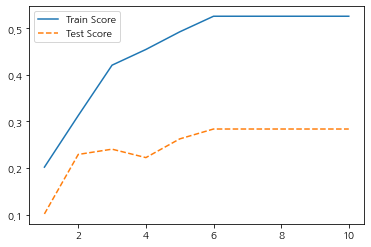

In [230]:
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.legend()

In [290]:
# tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=10, min_samples_split=22, max_depth = 4)
# tree_graph.fit(df_train_x, df_train_y)
# v_feature_name = df_train_x.columns
# fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (4,4), dpi = 300)
# plot_tree(tree_graph, feature_names = v_feature_name, filled = True);

In [237]:
tree_final = DecisionTreeRegressor(random_state=1234, min_samples_leaf=10, min_samples_split=22, max_depth = 4)
tree_final.fit(df_train_x, df_train_y)

print("Score on training set:{:.3f}".format(tree_final.score(df_train_x, df_train_y)))
print("Score on test set:{:.3f}".format(tree_final.score(df_test_x, df_test_y)))

Score on training set:0.454
Score on test set:0.222


의사결정나무 모델에서 min_samples_leaf=10, min_samples_split=22, max_depth = 4로 설정하였고 그 결과, train은 45.4%, test는 22.2%의 설명력을 갖는다.

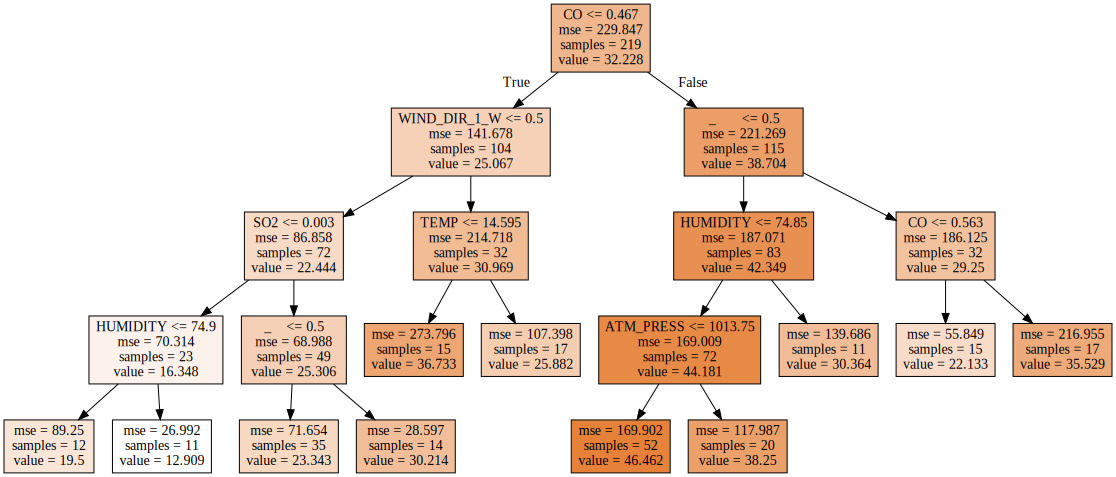

In [238]:
export_graphviz(tree_final, out_file="tree_final.dot", feature_names = v_feature_name, impurity=True, filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

설명 변수의 중요도를 살펴 보기 위해 아래와 같은 작업을 실행하였다.

In [239]:
df_importance=pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
1,CO,0.507
6,계절_가을,0.173
5,HUMIDITY,0.091
17,WIND_DIR_1_W,0.070
2,SO2,0.055
3,ATM_PRESS,0.043
4,TEMP,0.041
8,계절_봄,0.021
0,NO2,0.000
14,WIND_DIR_1_S,0.000


Text(0, 0.5, '변수')

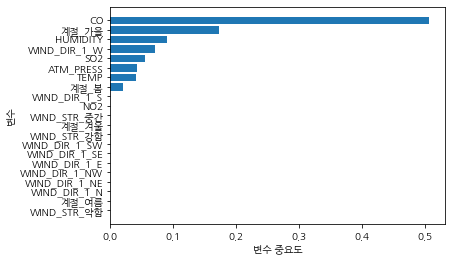

In [240]:
df_importance.sort_values("Importance", ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### 3) 랜덤 포레스트

In [241]:
req_data2

,PM10,NO2,CO,SO2,ATM_PRESS,TEMP,HUMIDITY,계절,WIND_DIR_1,WIND_STR
0,29.0,0.021,0.5,0.003,995.1,24.03,63.2,여름,W,중간
1,26.0,0.020,0.5,0.003,998.6,24.29,63.2,여름,W,중간
2,30.0,0.023,0.4,0.003,998.3,24.18,65.3,여름,W,중간
3,28.0,0.026,0.4,0.003,996.6,25.35,58.6,여름,W,중간
4,29.0,0.035,0.5,0.003,993.5,27.30,45.5,여름,S,약함
...,...,...,...,...,...,...,...,...,...,...
360,19.0,0.016,0.4,0.003,996.0,21.66,84.0,여름,SW,강함
361,22.0,0.017,0.4,0.004,995.8,23.94,69.8,여름,SW,중간
362,27.0,0.009,0.4,0.003,994.7,25.03,71.3,여름,W,중간
363,36.0,0.028,0.6,0.003,992.9,24.06,75.5,여름,E,중간


In [242]:
df_raw_dummy = pd.get_dummies(req_data2)
df_raw_dummy.head()

,PM10,NO2,CO,SO2,ATM_PRESS,TEMP,HUMIDITY,계절_가을,계절_겨울,계절_봄,...,WIND_DIR_1_N,WIND_DIR_1_NE,WIND_DIR_1_NW,WIND_DIR_1_S,WIND_DIR_1_SE,WIND_DIR_1_SW,WIND_DIR_1_W,WIND_STR_강함,WIND_STR_약함,WIND_STR_중간
0,29.0,0.021,0.5,0.003,995.1,24.03,63.2,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,26.0,0.020,0.5,0.003,998.6,24.29,63.2,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,30.0,0.023,0.4,0.003,998.3,24.18,65.3,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,28.0,0.026,0.4,0.003,996.6,25.35,58.6,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,29.0,0.035,0.5,0.003,993.5,27.30,45.5,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [243]:
df_raw_y = df_raw_dummy["PM10"]
df_raw_x = df_raw_dummy.drop("PM10", axis = 1, inplace = False)

In [244]:
rf_uncustomized = RandomForestRegressor(random_state = 1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.912
Score on test set: 0.454


기본으로 설정된 랜덤포레스트의 경우 train은 91.2%인 반면 test는 45.4%로 과대적합하다고 할 수 있다.

In [245]:
rf_uncustomized.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}

In [246]:
train_score = []; test_score = []
para_n_tree = [n_tree * 5 for n_tree in range(1,20)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators= v_n_estimators, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,5,0.820,0.354
1,10,0.873,0.359
2,15,0.889,0.432
3,20,0.900,0.433
4,25,0.904,0.419
5,30,0.905,0.435
6,35,0.907,0.445
7,40,0.914,0.458
8,45,0.912,0.461
9,50,0.911,0.462


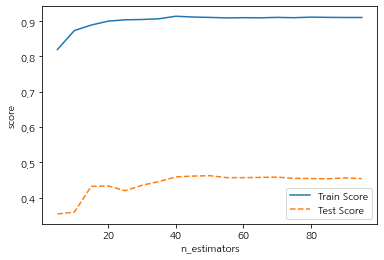

In [247]:
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label="Test Score")
plt.ylabel("score");plt.xlabel("n_estimators")
plt.legend()

In [248]:
train_score = []; test_score = []
para_n_tree = [n_leaf * 10 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(random_state=1234, n_estimators=50,min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSampelsLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

df_score_leaf.round(3)

,MinSampelsLeaf,TrainScore,TestScore
0,1,0.911,0.462
1,2,0.845,0.461
2,3,0.787,0.471
3,4,0.738,0.453
4,5,0.699,0.446
5,6,0.669,0.443
6,7,0.636,0.431
7,8,0.615,0.432
8,9,0.591,0.428
9,10,0.574,0.416


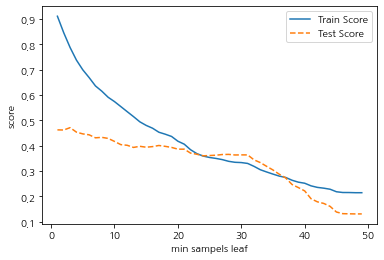

In [249]:
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test Score")
plt.ylabel("score");plt.xlabel("min sampels leaf")
plt.legend()

In [250]:
train_score = []; test_score = []
para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state=1234, n_estimators=50,min_samples_leaf=5, min_samples_split=v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.699,0.446
1,6,0.699,0.446
2,8,0.699,0.446
3,10,0.699,0.446
4,12,0.683,0.443
5,14,0.665,0.441
6,16,0.650,0.435
7,18,0.637,0.433
8,20,0.626,0.426
9,22,0.611,0.422


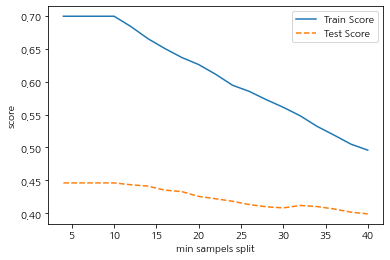

In [251]:
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.ylabel("score");plt.xlabel("min sampels split")
plt.legend()

In [252]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(random_state=1234, n_estimators=50,min_samples_leaf=5, min_samples_split=10, max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.248,0.269
1,2,0.409,0.371
2,3,0.523,0.421
3,4,0.616,0.431
4,5,0.662,0.439
5,6,0.686,0.444
6,7,0.696,0.447
7,8,0.698,0.447
8,9,0.699,0.446
9,10,0.699,0.446


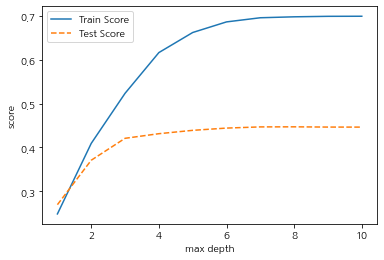

In [253]:
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.ylabel("score");plt.xlabel("max depth")
plt.legend()

In [254]:
rf_final = RandomForestRegressor(random_state=1234, n_estimators=50, min_samples_leaf=5, min_samples_split=10, max_depth=8)
rf_final.fit(df_train_x, df_train_y)

print("Score on training set:{:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Score on test set:{:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Score on training set:0.698
Score on test set:0.447


랜덤포레스트 모델에서 n_estimators=50, min_samples_leaf=5, min_samples_split=10, max_depth=8로 설정하였고 그 결과, train은 69.8%, test는 44.7%의 설명력을 갖는다.

In [255]:
df_importance=pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
1,CO,0.389
5,HUMIDITY,0.135
3,ATM_PRESS,0.085
8,계절_봄,0.080
4,TEMP,0.079
0,NO2,0.072
6,계절_가을,0.060
17,WIND_DIR_1_W,0.045
2,SO2,0.024
10,WIND_DIR_1_E,0.007


Text(0, 0.5, '변수')

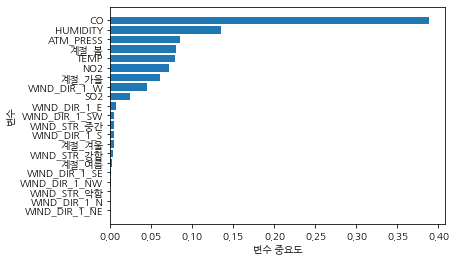

In [256]:
df_importance.sort_values("Importance", ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

**GridSearchCV를 이용한 최적 parameter 찾기**

In [257]:
# estimator = RandomForestRegressor(random_state=1234)
# param_grid={"max_depth":para_depth, "min_samples_split":para_split, "min_samples_leaf":para_leaf}

# grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs = -1)
# grid_dt.fit(df_train_x, df_train_y)

# print("best estimator model: \n{}".format(grid_dt.best_estimator_))
# print("\nbest parameter:\n{}".format(grid_dt.best_params_))
# print("\nbest score:\n{}".format(grid_dt.best_score_.round(3)))

### 4) 그래디언트 부스팅

In [258]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [259]:
req_data2

,PM10,NO2,CO,SO2,ATM_PRESS,TEMP,HUMIDITY,계절,WIND_DIR_1,WIND_STR
0,29.0,0.021,0.5,0.003,995.1,24.03,63.2,여름,W,중간
1,26.0,0.020,0.5,0.003,998.6,24.29,63.2,여름,W,중간
2,30.0,0.023,0.4,0.003,998.3,24.18,65.3,여름,W,중간
3,28.0,0.026,0.4,0.003,996.6,25.35,58.6,여름,W,중간
4,29.0,0.035,0.5,0.003,993.5,27.30,45.5,여름,S,약함
...,...,...,...,...,...,...,...,...,...,...
360,19.0,0.016,0.4,0.003,996.0,21.66,84.0,여름,SW,강함
361,22.0,0.017,0.4,0.004,995.8,23.94,69.8,여름,SW,중간
362,27.0,0.009,0.4,0.003,994.7,25.03,71.3,여름,W,중간
363,36.0,0.028,0.6,0.003,992.9,24.06,75.5,여름,E,중간


In [260]:
df_raw_y = df_raw_dummy["PM10"]
df_raw_x = df_raw_dummy.drop("PM10", axis = 1, inplace = False)

In [261]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.4, random_state = 1234)
#train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test데이터 비율, random_state:random seed)
print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (219, 21)
train data Y size: (219,)
test data X size: (146, 21)
test data Y size: (146,)


In [262]:
gb_uncustomized = GradientBoostingRegressor(random_state = 1234)
gb_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.915
Score on test set: 0.424


기본으로 설정된 그래디언트 부스팅의 경우 train은 91.5%인 반면 test는 42.4%로 과대적합하다고 할 수 있다.

In [263]:
gb_uncustomized.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 1234,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [264]:
train_score = []; test_score = []
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators= v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["Estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

df_score_n.round(3)

,Estimators,TrainScore,TestScore
0,10,0.480,0.308
1,20,0.635,0.382
2,30,0.720,0.414
3,40,0.776,0.430
4,50,0.815,0.438
5,60,0.841,0.437
6,70,0.863,0.442
7,80,0.882,0.439
8,90,0.898,0.430
9,100,0.915,0.424


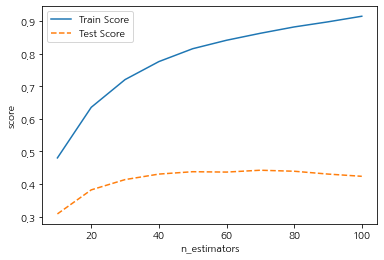

In [265]:
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label="Test Score")
plt.ylabel("score");plt.xlabel("n_estimators")
plt.legend()

In [266]:
train_score = []; test_score = []
para_n_tree = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = GradientBoostingRegressor(random_state=1234, n_estimators=70,min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.863,0.442
1,2,0.843,0.452
2,3,0.838,0.451
3,4,0.841,0.432
4,5,0.829,0.421
5,6,0.827,0.442
6,7,0.820,0.431
7,8,0.812,0.416
8,9,0.802,0.402
9,10,0.796,0.421


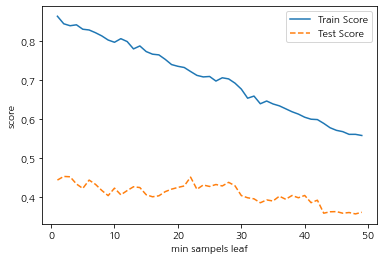

In [267]:
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test Score")
plt.ylabel("score");plt.xlabel("min sampels leaf")
plt.legend()

In [268]:
train_score = []; test_score = []
para_split = [n_split * 2 for n_split in range(1,21)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=70,min_samples_leaf=22, min_samples_split=v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.721,0.45
1,4,0.721,0.45
2,6,0.721,0.45
3,8,0.721,0.45
4,10,0.721,0.45
5,12,0.721,0.45
6,14,0.721,0.45
7,16,0.721,0.45
8,18,0.721,0.45
9,20,0.721,0.45


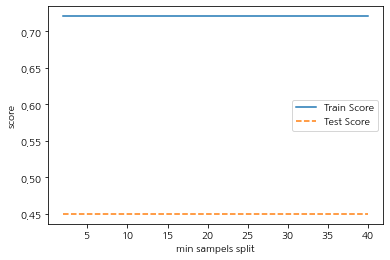

In [269]:
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.ylabel("score");plt.xlabel("min sampelsdy>
		<div style="background-color:cyan">구역1</div>
		<div style="width:100px; hei split")
plt.legend()

In [270]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=70,min_samples_leaf=22, max_depth = v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.468,0.370
1,2,0.639,0.441
2,3,0.721,0.450
3,4,0.771,0.434
4,5,0.781,0.429
5,6,0.786,0.440
6,7,0.784,0.430
7,8,0.784,0.430
8,9,0.784,0.430
9,10,0.784,0.430


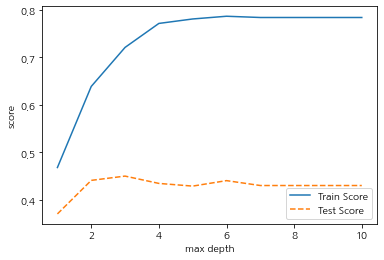

In [271]:
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.ylabel("score");plt.xlabel("max depth")
plt.legend()

In [272]:
train_score = []; test_score = []
para_lr = [lr * 0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=70,min_samples_leaf=22, max_depth =3, learning_rate = v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["LearningRate"] = para_lr
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

df_score_depth.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.721,0.450
1,0.2,0.816,0.423
2,0.3,0.873,0.392
3,0.4,0.900,0.369
4,0.5,0.917,0.344
5,0.6,0.932,0.342
6,0.7,0.950,0.317
7,0.8,0.960,0.277
8,0.9,0.964,0.351


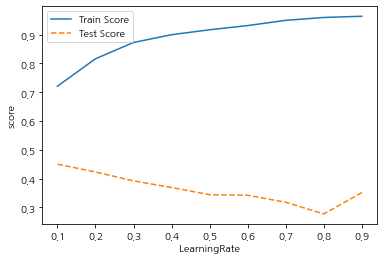

In [273]:
plt.plot(para_lr, train_score, linestyle="-", label="Train Score")
plt.plot(para_lr, test_score, linestyle="--", label="Test Score")
plt.ylabel("score");plt.xlabel("LearningRate")
plt.legend()

최종 모델

In [274]:
gb_final = GradientBoostingRegressor(random_state=1234, n_estimators=70, min_samples_leaf=22, max_depth=3,learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)

print("Score on training set:{:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Score on test set:{:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set:0.721
Score on test set:0.450


랜덤포레스트 모델에서 n_estimators=70, min_samples_leaf=22, max_depth=3, learning_rate=0.1로 설정하였고 그 결과, train은 72.1%, test는 45.0%의 설명력을 갖는다.

In [275]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=gb_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
1,CO,0.371
5,HUMIDITY,0.142
4,TEMP,0.098
8,계절_봄,0.097
6,계절_가을,0.078
3,ATM_PRESS,0.072
17,WIND_DIR_1_W,0.062
0,NO2,0.031
2,SO2,0.026
10,WIND_DIR_1_E,0.012


Text(0, 0.5, '변수')

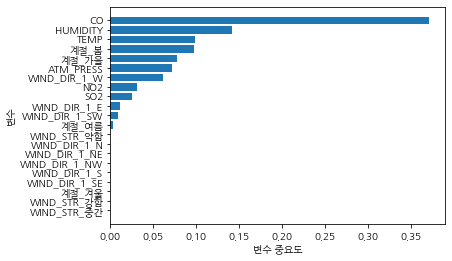

In [276]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [277]:
# estimator = GradientBoostingRegressor(random_state=1234)
# param_grid={"crieterion": ["mse", "friedman_mse", "mae"], "max_features": ["auto", "sqrt", "log2"], "learning_rate" : para_lr, "max_depth":para_depth, "min_samples_leaf":para_leaf}

# grid_gb = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs = -1)
# grid_gb.fit(df_train_x, df_train_y)

# print("best estimator model: \n{}".format(grid_gb.best_estimator_))
# print("\nbest parameter:\n{}".format(grid_gb.best_params_))
# print("\nbest score:\n{}".format(grid_gb.best_score_.round(3)))

## 6. 모델 평가

In [278]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#평가 함수 정의
# RMSE: root mean squared error 함수
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE: mean abslute percentage error 함수
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [279]:
reg_model = smf.ols(formula = "PM10 ~ O3 + NO2 + CO + SO2 + TEMP + RAIN + WIND + WIND_DIR + HUMIDITY + ATM_PRESS + SNOW + CLOUD", data=df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     29.59
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           2.45e-46
Time:                        08:58:07   Log-Likelihood:                -1400.7
No. Observations:                 365   AIC:                             2827.
Df Residuals:                     352   BIC:                             2878.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    429.7116    162.179      2.650      0.0

In [280]:
dt_model = DecisionTreeRegressor(random_state=1234, min_samples_leaf=10, min_samples_split=22, max_depth = 4)
dt_model.fit(df_train_x, df_train_y)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=22,
                      random_state=1234)

In [281]:
rf_model = RandomForestRegressor(random_state=1234, n_estimators=50, min_samples_leaf=5, min_samples_split=10, max_depth=8)
rf_model.fit(df_train_x, df_train_y)

RandomForestRegressor(max_depth=8, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=50, random_state=1234)

In [282]:
gb_model = GradientBoostingRegressor(random_state=1234, n_estimators=70, min_samples_leaf=22, max_depth=3,learning_rate=0.1)
gb_model.fit(df_train_x, df_train_y)

GradientBoostingRegressor(min_samples_leaf=22, n_estimators=70,
                          random_state=1234)

In [283]:
# 모델 리스트, 그래프를 그리기 생성 목적
models = ["의사결정나무", "랜덤 포레스트", "그래디언트 부스팅"]

# 평가 리스트 초기화
mse, rmse, mae, mape = [],[],[],[]

In [284]:
# 예측
dt_y_pred = dt_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y, dt_y_pred))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, dt_y_pred))

In [285]:
# 예측
rf_y_pred = rf_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y, rf_y_pred))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

In [286]:
# 예측
gb_y_pred = gb_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

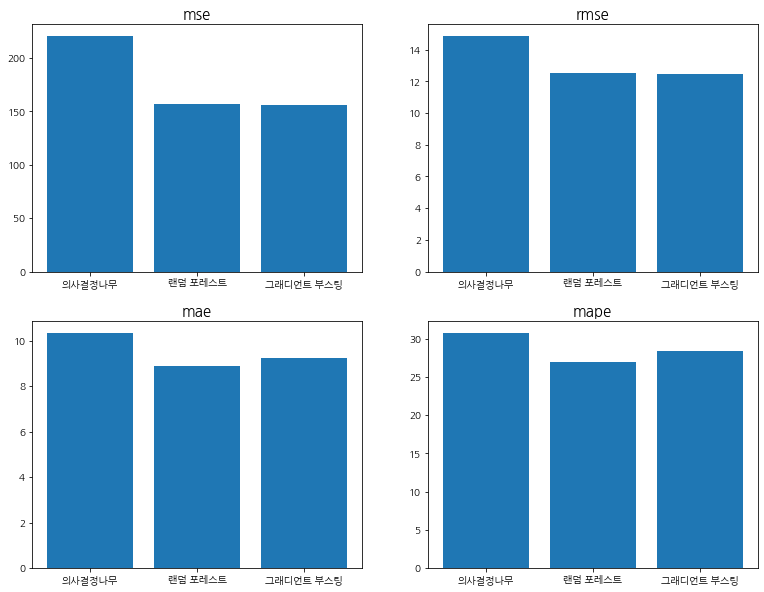

In [287]:
# 시각화 - 평가
fig, ax = plt.subplots(2,2, figsize = (13,10))
ax[0,0].bar(models, mse)
ax[0,0].set_title("mse").set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title("rmse").set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title("mae").set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title("mape").set_fontsize(15)


의사결정나무, 랜덤포레스트, 그래디언트 부스팅을 비교한 결과, 랜덤 포레스트 혹은 그래디언트 부스팅의 모델링이 더 우수하다는 것을 알 수 있다.